#  Лабораторная работа №1. Метод ближайших соседей

##### Покупка квартиры в Москве - важный шаг для людей, желающих иметь свою жилплощадь в прекрасной столице нашей Родины и располагающих кругленькой суммой. Однако множество подводных камней может встретиться на пути потенциального покупателя. Найдёшь квартиру по привлекательной цене в неплохом доме, и этаж устраивает, и площадь, и даже расстояние от центра города - понятно ведь, что рассматриваешь спальные районы. Но подожди-ка... А если на работу ездить и вообще по делам? Да и просто культурный досуг проводить. Не всё же около дома есть - Москва большая! Естественно, Московский метрополитен в помощь. Но не всегда из объявления понятно, сколько же минут придётся добираться пешком до ближайшей станции. Возьмём набор данных, содержащий различные параметры квартир, выставленных на продажу, и приступим к созданию алгоритма, который и будет определять, находится ли в пешей доступности от метро какая-либо квартира, которую ты, возможно, скоро приобретёшь на свои кровно заработанные денежки.

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import  pickle
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [105]:
data = pd.read_csv('flats_moscow.csv', sep=',')
#просмотрим несколько записей из набора  данных
data.head(10)

,Unnamed: 0,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,1,81,58,40,6.0,12.5,7,1,1,1,3
1,2,75,44,28,6.0,13.5,7,1,0,1,6
2,3,128,70,42,6.0,14.5,3,1,1,1,3
3,4,95,61,37,6.0,13.5,7,1,0,1,1
4,5,330,104,60,11.0,10.5,7,0,1,1,3
5,6,137,76,50,9.0,11.0,7,1,1,1,8
6,7,98,59,39,6.0,7.5,10,0,0,1,8
7,8,88,55,36,6.0,9.0,5,1,1,0,4
8,9,225,80,56,9.0,9.0,5,1,1,1,3
9,10,140,86,51,10.0,12.7,10,1,0,1,5


![title](image/1.jpg)

In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2040 non-null   int64  
 1   price       2040 non-null   int64  
 2   totsp       2040 non-null   int64  
 3   livesp      2040 non-null   int64  
 4   kitsp       2040 non-null   float64
 5   dist        2040 non-null   float64
 6   metrdist    2040 non-null   int64  
 7   walk        2040 non-null   int64  
 8   brick       2040 non-null   int64  
 9   floor       2040 non-null   int64  
 10  code        2040 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 175.4 KB


Как видно из информации, у нас отсутствуют пропуски данных.

### Описание датасета
Price - цена квартиры в $1000

totsp - общая площадь квартиры, кв.м.

livesp - жилая площадь квартиры, кв.м.

kitsp - площадь кухни, кв.м.

dist - расстояние от центра в км.

metrdist - расстояние до метро в минутах

walk - 1 – пешком от метро, 0 – на транспорте

brick - 1 – кирпичный, монолит ж/б, 0 – другой

floor - 1 – этаж кроме первого и последнего, 0 – иначе.

code - число от 1 до 8, при помощи которого мы группируем наблюдения по подвыборкам: 
   1. Наблюдения сгруппированы на севере, вокруг Калужско-Рижской линии метрополитена 
   2. Север, вокруг Серпуховско-Тимирязевской линии метрополитена 
   3. Северо-запад, вокруг Замоскворецкой линии метрополитена 
   4. Северо-запад, вокруг Таганско-Краснопресненской линии метрополитена 
   5. Юго-восток, вокруг Люблинской линии метрополитена 
   6. Юго-восток, вокруг Таганско-Краснопресненской линии метрополитена 
   7. Восток, вокруг Калиниской линии метрополитена 
   8. Восток, вокруг Арбатско-Покровской линии метрополитена

В нашей выборке есть признак "номер". Очевидно, что он нам не потребуется. Выбросим его из выборки

In [107]:
data = data.drop(['Unnamed: 0'], axis='columns')

Посмотрим, можем ли мы выбросить еще какие-нибудь признаки из нашей таблицы. Посмотрим на корреляцию признаков между собой. Для этого построим графическое предствление модуля корреляции попарно между признаками. 

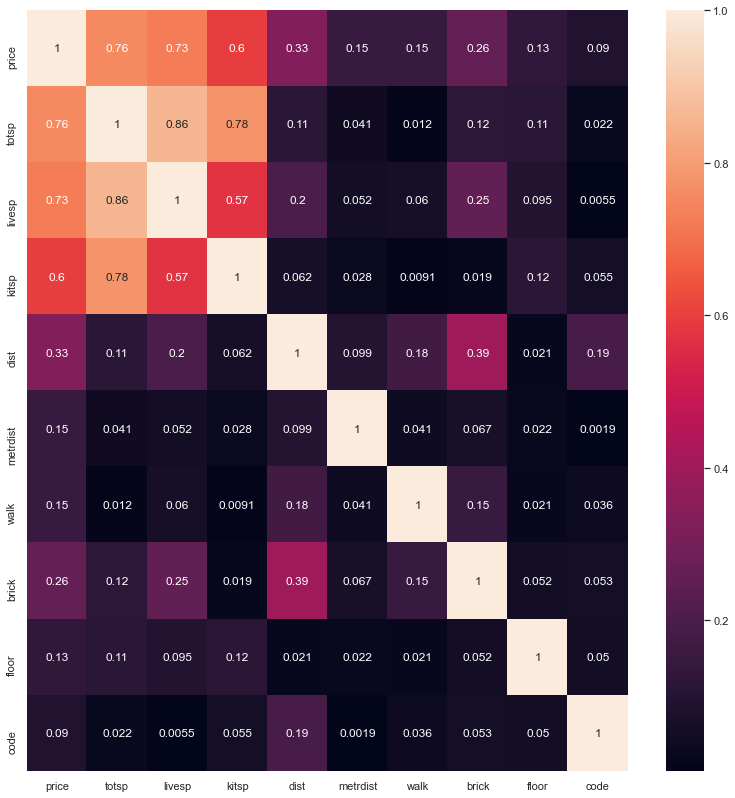

In [108]:
#Картинку рисуем с помощью библиотеки seaborn
import seaborn as sns
#Подсчитаем корреляцию и возьмем модуль от нее
corr = data.corr().abs()
sns.set(rc={'figure.figsize': (12, 14)})
#Нарисуем картинку с аннтоацией 
sns.heatmap(corr, 
            xticklabels=corr.columns.values, 
            yticklabels=corr.columns.values,
            annot=True)

Удалим из выборки признаки, высоко коррелирующие с другими признаками. В нашей выборке- это общая площадь квартиры, жилая площадь и площадь кухни.

![title](image/2.jpg)

In [109]:
data = data.drop(['totsp', 'livesp', 'kitsp',], axis='columns')

Посмотрим на признаки, которые остались после прореживания.

In [110]:
data.head()

,price,dist,metrdist,walk,brick,floor,code
0,81,12.5,7,1,1,1,3
1,75,13.5,7,1,0,1,6
2,128,14.5,3,1,1,1,3
3,95,13.5,7,1,0,1,1
4,330,10.5,7,0,1,1,3


In [111]:
data.dtypes

price         int64
dist        float64
metrdist      int64
walk          int64
brick         int64
floor         int64
code          int64
dtype: object

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     2040 non-null   int64  
 1   dist      2040 non-null   float64
 2   metrdist  2040 non-null   int64  
 3   walk      2040 non-null   int64  
 4   brick     2040 non-null   int64  
 5   floor     2040 non-null   int64  
 6   code      2040 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 111.7 KB


### Время machine  learning  
 Выделим в нашей выборке целевую переменную, а также разделим ее на тренировочную и тестовую.

In [113]:
x = data.drop(['walk'], axis='columns')
y = data['walk']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  =  train_test_split(x, y)

Будем производить классификацию с помощью метода ближайщих соседей.

In [114]:
from sklearn.neighbors import KNeighborsClassifier

# создадим наш классификатор. Гиперпараметр у этого алгоритма один - количество соседей.
clf= KNeighborsClassifier(n_neighbors=5)
# обучим классификатор на тренеровочной выборке
clf.fit(X_train, y_train)
# подсчитаем долю верных ответов
clf.score(X_test, y_test)

0.6568627450980392

Посмотрим как гиперпараметр влияет на  качество классификации.

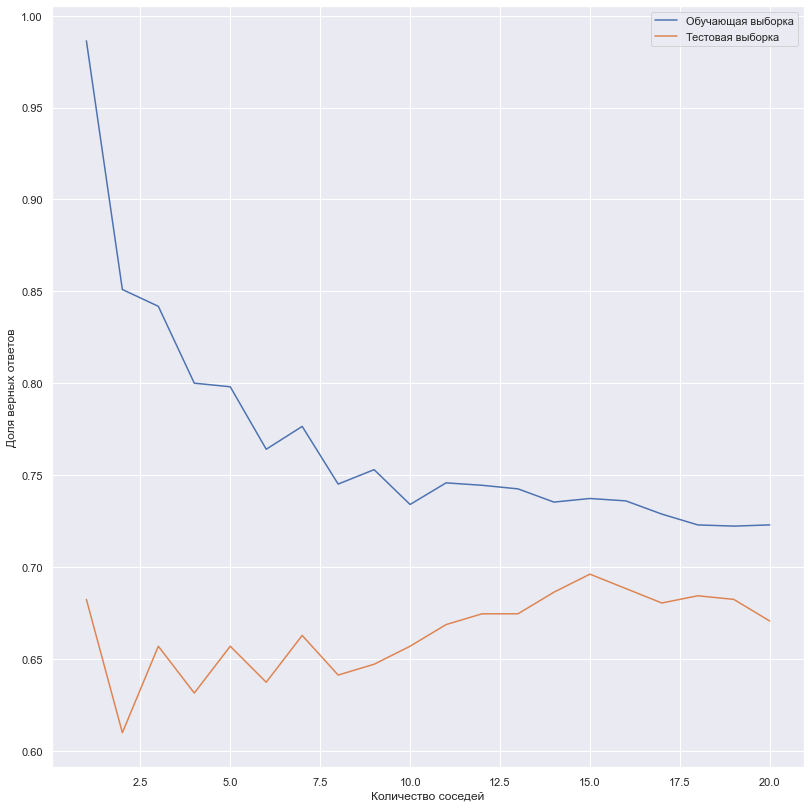

In [115]:
# Создадим пустой словарь. Будем добавлять в него значения наших "скоров". Ключами будет значение гиперпараметра,
# значениями - качество работы. Рассмотрим отдельно качество на тренировочной выборке и на тестовой.
train_scores = {}
test_scores = {}

# для n в диапазоне от 1 до 20 включительно
for n in range(1, 21):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train, y_train)
    # значение качества на текущей итерации:
    current_train_score = clf.score(X_train, y_train)
    current_test_score = clf.score(X_test, y_test)
    # запишем его в наши словари
    train_scores[n] = current_train_score
    test_scores[n] = current_test_score

    
# нарисуем графики

plt.plot(list(train_scores.keys()), list(train_scores.values()), label='Обучающая выборка')
plt.plot(list(test_scores.keys()), list(test_scores.values()), label='Тестовая выборка')
plt.xlabel('Количество соседей')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Согласно заданию лабораторной работы №2 обернем все действия в Pipeline и сохраним модель в pickle

In [116]:
pipeline = make_pipeline(              
    
    MinMaxScaler(),                               # нормализацию
    KNeighborsClassifier(n_neighbors=1),          # и сам классификатор с наилучшими параметрами
)

pipeline

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])

In [117]:
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.7509803921568627

In [118]:
with open("LR_1.pickle", 'wb') as opened_file:
    pickle.dump(pipeline, opened_file)

##  Вывод
В рамках выполнения данной работы была поставлена задача классификации объектов по целевому признаку "Шаговая доступность от метро", проведена предварительная обработка данных, в частности, удаление высококоррелирующих признаков. Также было выявлено оптимальное количество соседей для метода KNN.

#  Лабораторная работа №2. Разведочный анализ данных
Вспомним, что за набор данных был в прошлый раз

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.pylabtools import figsize
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

%matplotlib inline
figsize(10, 10) # зададим размер картинки



data = pd.read_csv('flats_moscow.csv',  sep=',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2040 non-null   int64  
 1   price       2040 non-null   int64  
 2   totsp       2040 non-null   int64  
 3   livesp      2040 non-null   int64  
 4   kitsp       2040 non-null   float64
 5   dist        2040 non-null   float64
 6   metrdist    2040 non-null   int64  
 7   walk        2040 non-null   int64  
 8   brick       2040 non-null   int64  
 9   floor       2040 non-null   int64  
 10  code        2040 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 175.4 KB


Почистим данные как в прошлый раз и разделим  выборку на тестовую и обучающую.

In [120]:
data = data.drop(['Unnamed: 0'], axis='columns')

data = data.drop(['totsp', 'livesp', 'kitsp',], axis='columns')
x = data.drop(['walk'], axis='columns')
y = data['walk']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  =  train_test_split(x, y)

### Структура  данных
Посмотрим на распределения и возможные зависимости признаков. 

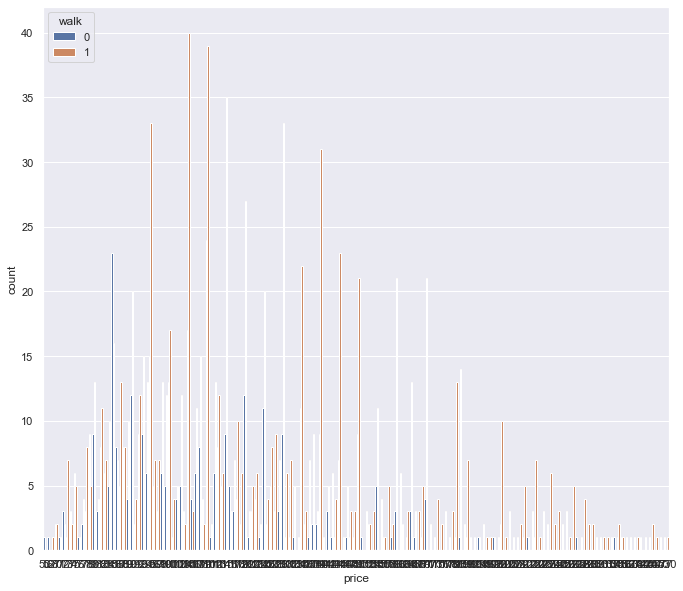

In [121]:
sns.countplot(X_train['price'], hue=y_train)

Как видно цена квартиры не дает существеную информацию о том, что  квартира  находится в  шаговой  доступности от метро. Взглянем  на зависимости от других параметров
![title](image/3.jpg)

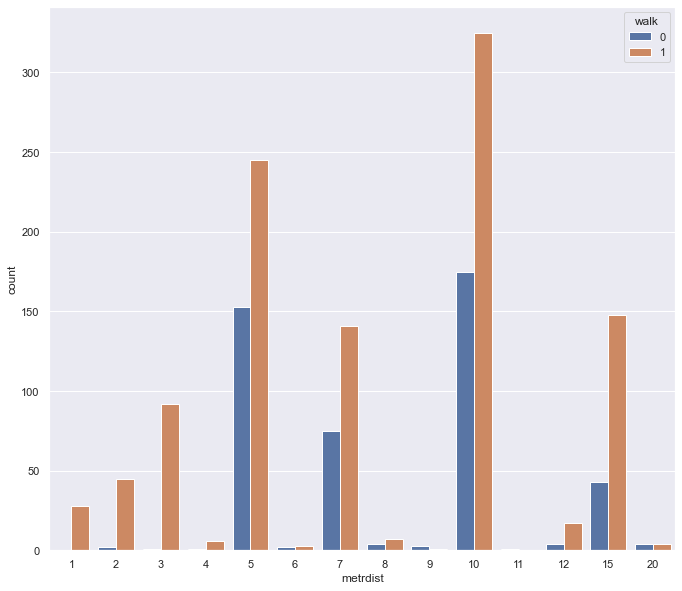

In [122]:
sns.countplot(X_train['metrdist'], hue=y_train)

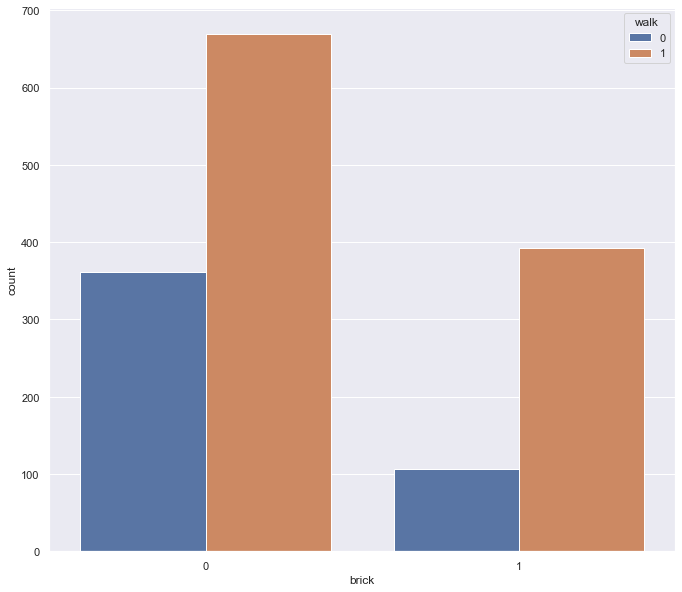

In [123]:
sns.countplot(X_train['brick'], hue=y_train)

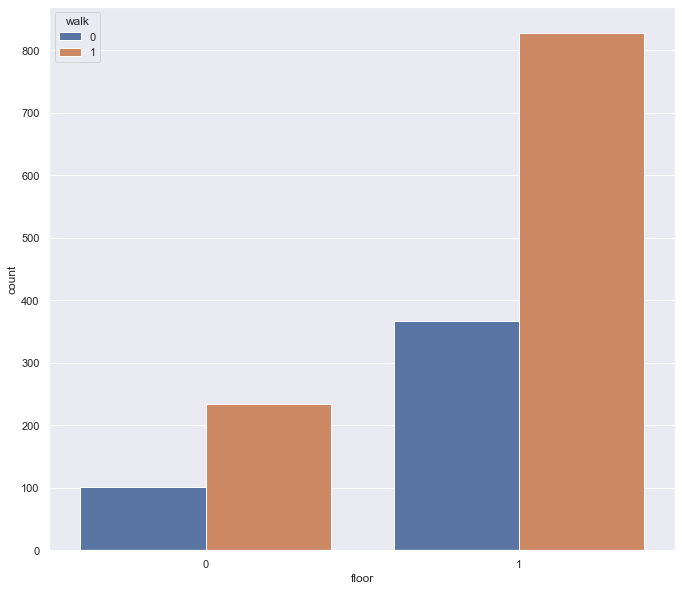

In [124]:
sns.countplot(X_train['floor'], hue=y_train)

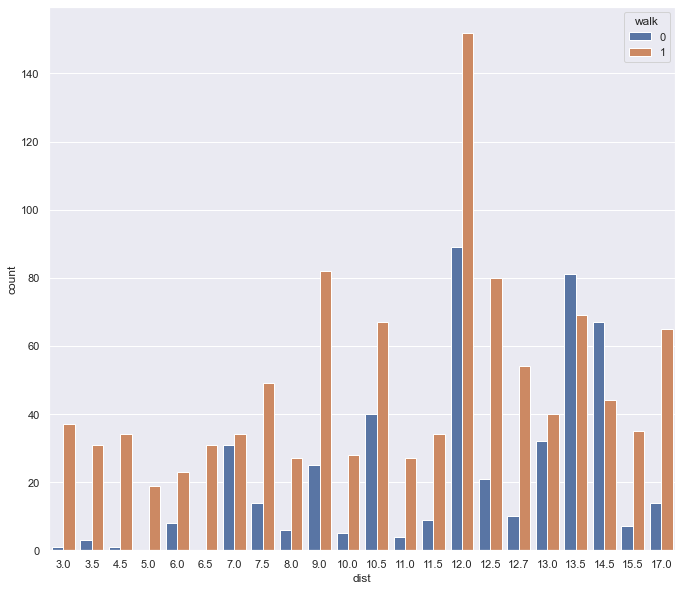

In [125]:
sns.countplot(X_train['dist'], hue=y_train)

##### Посмотрим  как  распределны  относительно  друг  друга

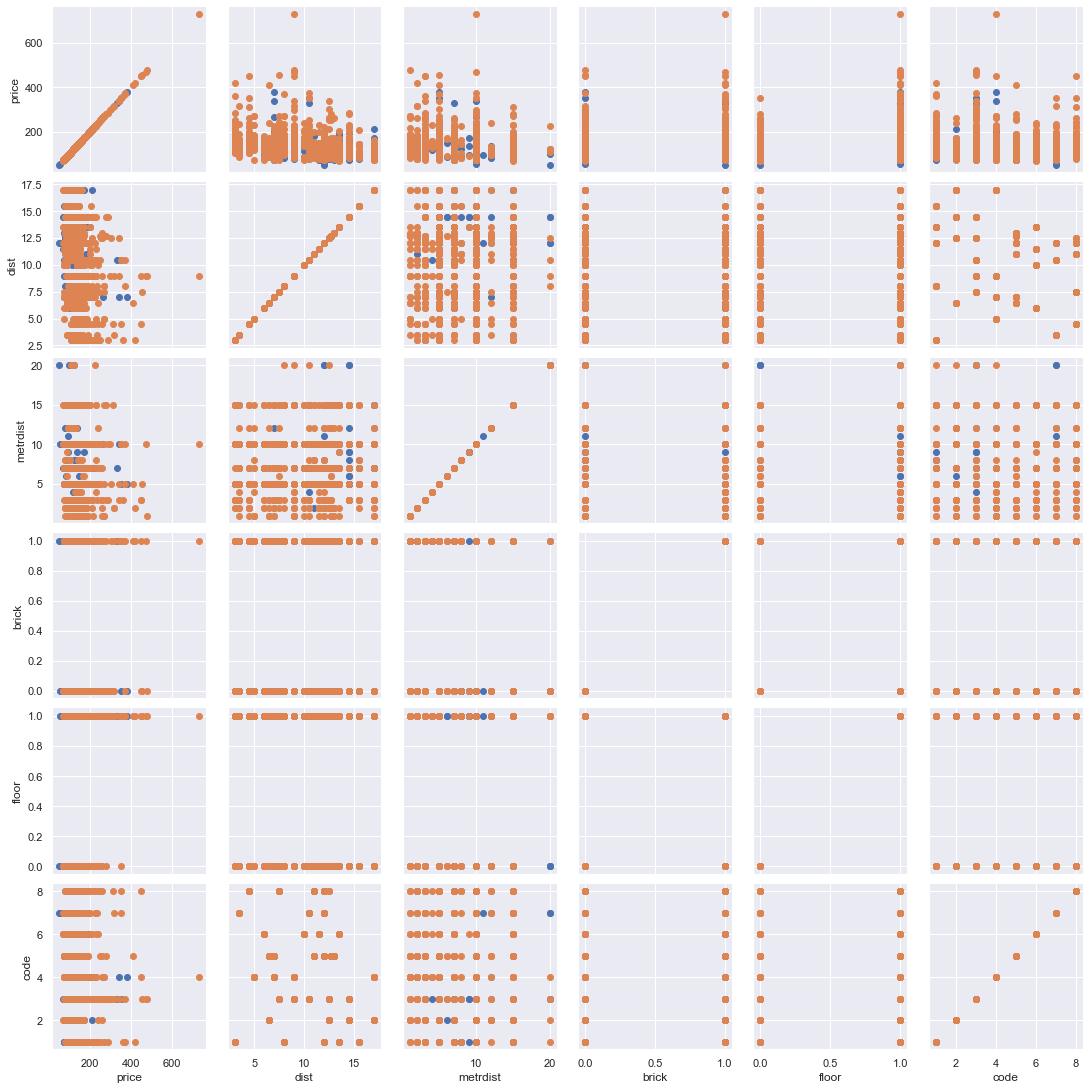

In [126]:
df_for_pairgrid = X_train[['price', 'dist', 'metrdist',  'brick',  'floor', 'code' ]]
df_for_pairgrid['walk'] = y_train

sns.PairGrid(df_for_pairgrid, hue='walk').map(plt.scatter)

![title](image/4.jpg)

## Выбросы.
Взгялнем их на boxplot'e.

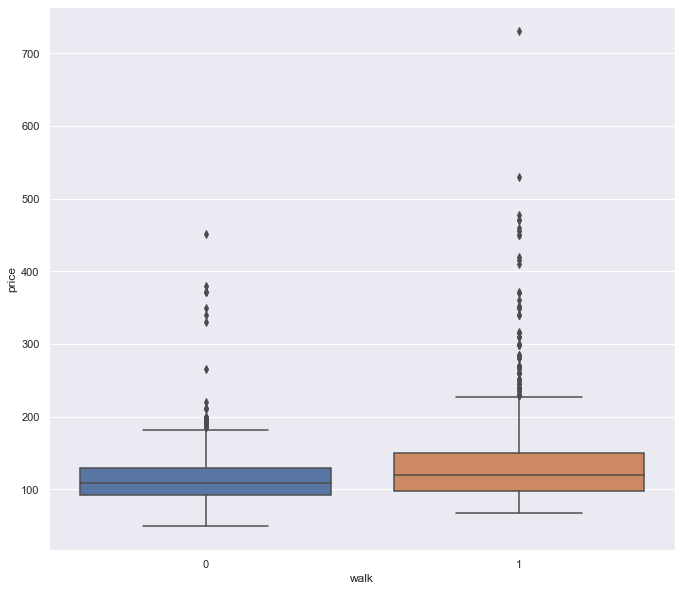

In [127]:
vbros = pd.read_csv('flats_moscow.csv',  sep=',')['price']
sns.boxplot(x=y, y=vbros)

На графике скрипке посмотрим  на плотность распределения величины. 

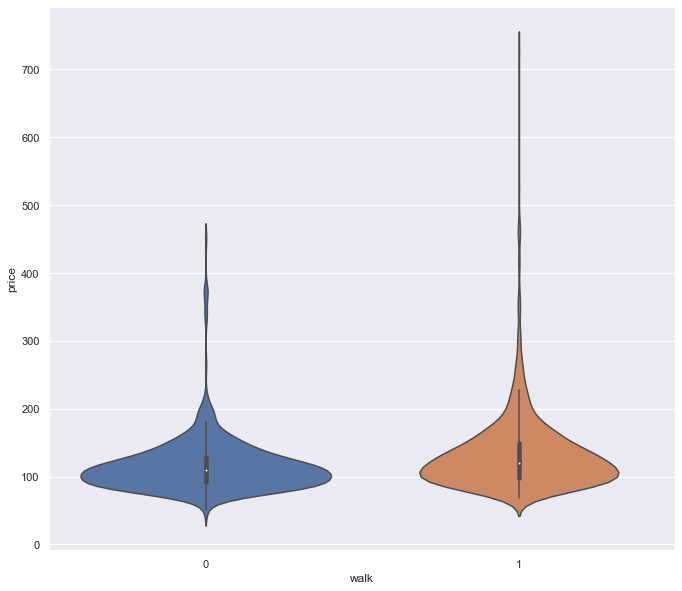

In [128]:
sns.violinplot(x=y, y=vbros)

##  Нормализация  признаков


Качество алгоритма до нормализации: 0.6901960784313725
Качество алгоритма после нормализации: 0.7627450980392156


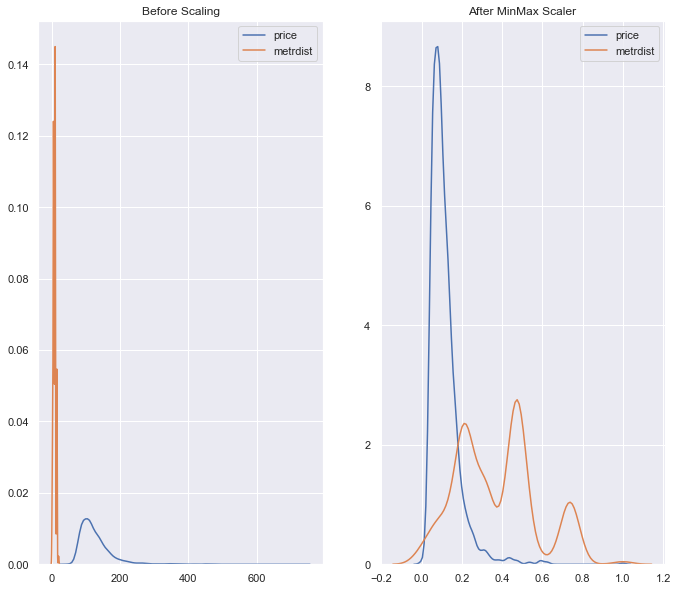

In [129]:
print("Качество алгоритма до нормализации:",
      KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train).score(X_test, y_test))

scaler = MinMaxScaler() #Произведем нормализацию признака.
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train, ), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

print("Качество алгоритма после нормализации:",
      KNeighborsClassifier(n_neighbors=1).fit(X_train_scaled, y_train).score(X_test_scaled, y_test))

# графики
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_title('Before Scaling')
sns.kdeplot(X_train['price'], ax=ax1)
sns.kdeplot(X_train['metrdist'], ax=ax1)
ax2.set_title('After MinMax Scaler')
sns.kdeplot(X_train_scaled['price'], ax=ax2)
sns.kdeplot(X_train_scaled['metrdist'], ax=ax2)
plt.show()

##  Подбор алгоритма
Не всегда можно понять по визуализации данных, какой алгоритм может хорошо сработать Чтобы понять, над какой моделью можно работать, посмотрим на качество на нескольких простых моделях.

In [130]:
for clf in [DecisionTreeClassifier(), SGDClassifier(), SVC(), GaussianNB(), KNeighborsClassifier()]:
    print(clf.__class__.__name__, clf.fit(X_train_scaled, y_train).score(X_test_scaled, y_test))

DecisionTreeClassifier 0.7392156862745098
SGDClassifier 0.6607843137254902
SVC 0.6607843137254902
GaussianNB 0.6490196078431373
KNeighborsClassifier 0.7568627450980392


##  Про стратификацию
Посмотрим на распределение классов в тренировочной выборке.

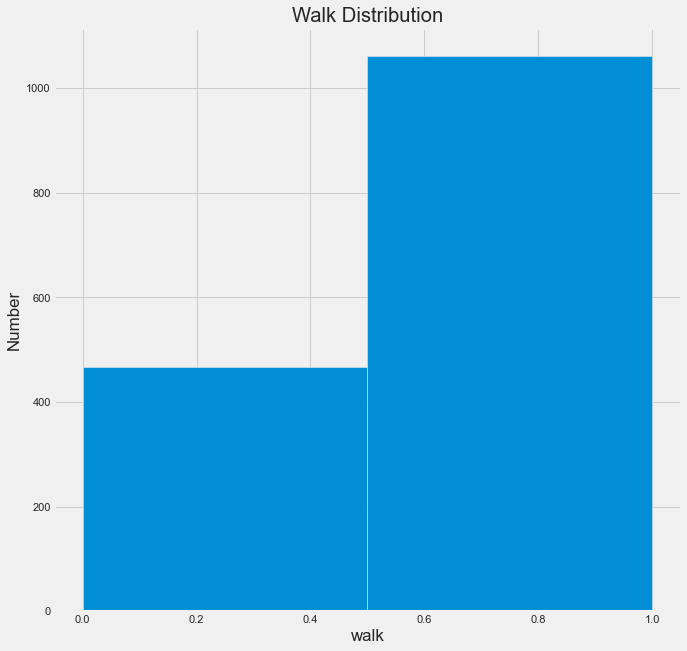

In [131]:
plt.style.use('fivethirtyeight')
plt.hist(y_train, bins=2);
plt.xlabel('walk'); plt.ylabel('Number');
plt.title('Walk Distribution');

In [132]:
a = np.ones(y_test.shape[0])
accuracy_score(y_test, a)

0.6607843137254902

Увеличим количество примеров из недоминантного класса.

In [133]:
X_train_scaled.reset_index(inplace=True, drop=True)
y_train.reset_index(drop=True, inplace=True)

In [134]:
walk = X_train_scaled[y_train == 0]
X_train_strat = pd.concat([X_train_scaled, walk], ignore_index=True)
y_train_strat = pd.concat([y_train, pd.Series(np.zeros(X_train_strat.shape[0]-X_train_scaled.shape[0]))],
                          ignore_index=True)



In [135]:
for clf in [DecisionTreeClassifier(), SGDClassifier(), SVC(), GaussianNB(), KNeighborsClassifier()]:
    print(clf.__class__.__name__, clf.fit(X_train_strat, y_train_strat).score(X_test_scaled, y_test))

DecisionTreeClassifier 0.7509803921568627
SGDClassifier 0.6274509803921569
SVC 0.6392156862745098
GaussianNB 0.5686274509803921
KNeighborsClassifier 0.7490196078431373


## Метрики качества
Посмотрим на предсказания константного классификатора

In [136]:
print('Accuracy:', accuracy_score(y_test, a))
print('Precision:', precision_score(y_test, a))
print('Recall:', recall_score(y_test, a))
print('ROC AUC:', roc_auc_score(y_test, a))
pr, rec, _ = precision_recall_curve(y_test, a)
print('PRC AUC:', auc(rec, pr))
print('F1:', f1_score(y_test, a))
print('F0.5:', fbeta_score(y_test, a, 0.5))
print('F2:', fbeta_score(y_test, a, 2))






Accuracy: 0.6607843137254902
Precision: 0.6607843137254902
Recall: 1.0
ROC AUC: 0.5
PRC AUC: 0.830392156862745
F1: 0.795749704840614
F0.5: 0.7088767353807319
F2: 0.9068891280947254


## Вывод
На основании поставленной задачи классификации делаем вывод, что метрика precision в данном случае важнее метрики recall. Так как recall нельзя совсем не учитывать, будем оценивать качество с помощью метрики F0.5.

# Лабораторная работа №3. Линейные  методы

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [138]:
data = pd.read_csv('flats_moscow.csv', sep=',')
#просмотрим несколько записей из набора  данных
data.head(10)

,Unnamed: 0,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,1,81,58,40,6.0,12.5,7,1,1,1,3
1,2,75,44,28,6.0,13.5,7,1,0,1,6
2,3,128,70,42,6.0,14.5,3,1,1,1,3
3,4,95,61,37,6.0,13.5,7,1,0,1,1
4,5,330,104,60,11.0,10.5,7,0,1,1,3
5,6,137,76,50,9.0,11.0,7,1,1,1,8
6,7,98,59,39,6.0,7.5,10,0,0,1,8
7,8,88,55,36,6.0,9.0,5,1,1,0,4
8,9,225,80,56,9.0,9.0,5,1,1,1,3
9,10,140,86,51,10.0,12.7,10,1,0,1,5


Почистим данные как в прошлый раз и разделим  выборку на тестовую и обучающую.

In [139]:
data = data.drop(['Unnamed: 0'], axis='columns')
x = data.drop(['walk'], axis='columns')
y = data['walk']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  =  train_test_split(x, y)

X_train_log=X_train
y_train_log=y_train
X_test_log=X_test


## Логистическая регрессия 
Обучим логистическую регрессию на своих данных без применения регуляризации.
![title](image/5.jpeg)

In [140]:
logreg = LogisticRegression(penalty='none', max_iter=10000) # penalty='none', т.к. обучим логистическую регрессию  без применения регуляризации
                                                            #max_iter ограничим, т.к. lbfgs выдавала ошибку
#обучаем модель данными
logreg.fit(X_train_log,y_train_log)
#выполним прогнозирование на тестовом наборе с помощью функции predict ()
y_pred=logreg.predict(X_test_log)


### Оценка модели с использованием  матрицы  ошибок

In [141]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 18, 129],
       [ 11, 352]], dtype=int64)

Визуализация матрицы ошибок с помощью тепловой карты

Text(0.5, 257.44, 'Предсказанные метки')

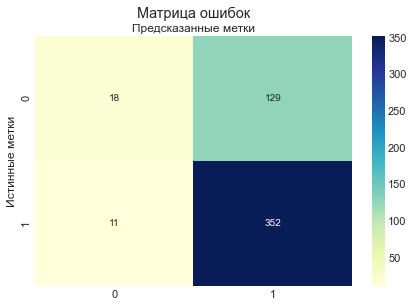

In [142]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Матрица ошибок', y=1.1)
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')

### Метрики качества


In [143]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7254901960784313
Precision: 0.7318087318087318
Recall: 0.9696969696969697


## Регуляризация логистической регресси
Произведем L1 и L2 регуляризации над нашими  данными

### Подбор параметров
Так же посмотрим на параметр С. Как  известно $$ C=\frac{1}{λ} $$
### L1 регуляризация

In [144]:

# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)
C = [100,10, 1, .1, .0001, .000001]
for c in C:
    clf = LogisticRegression(penalty='l1', C=c,  solver='liblinear' ) #liblinear, т.к. метод по умолчанию (lbfgs)
                                                                      # не поддерживает l1
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Test accuracy:', clf.score(X_test_std, y_test))
    print('Precision:', precision_score(y_test, y_pred))
    print('')

C: 100
Coefficient of each feature: [[ 0.02234017 -0.05079344  0.01508305 -0.0168657  -0.03232019  0.01032301
   0.39423297 -0.24317725 -0.0097294 ]]
Training accuracy: 0.677124183006536
Test accuracy: 0.711764705882353
Precision: 0.7318087318087318

C: 10
Coefficient of each feature: [[ 0.02236232 -0.0508365   0.0154069  -0.01691175 -0.03173605  0.01046541
   0.39290516 -0.24048598 -0.00911985]]
Training accuracy: 0.677124183006536
Test accuracy: 0.711764705882353
Precision: 0.7318087318087318

C: 1
Coefficient of each feature: [[ 0.02262331 -0.0519373   0.01958242 -0.01629187 -0.02562432  0.01189026
   0.37931627 -0.21366391 -0.00292607]]
Training accuracy: 0.677124183006536
Test accuracy: 0.711764705882353
Precision: 0.7302904564315352

C: 0.1
Coefficient of each feature: [[ 0.02362098 -0.05720831  0.04079782 -0.01293262 -0.00203048  0.01711387
   0.23653184 -0.00537322  0.01546203]]
Training accuracy: 0.5117647058823529
Test accuracy: 0.46862745098039216
Precision: 0.72107438016528

### L2 регуляризация

In [145]:
# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)
C = [10, 1, .1, .0001]
for c in C:
    clf = LogisticRegression(penalty='l2', C=c, max_iter=1000 )                                                            
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Test accuracy:', clf.score(X_test_std, y_test))
    print('Precision:', precision_score(y_test, y_pred))
    print('')

C: 10
Coefficient of each feature: [[ 0.02235608 -0.05093361  0.01521013 -0.01679884 -0.03238129  0.01023526
   0.39190545 -0.24170562 -0.00983872]]
Training accuracy: 0.677124183006536
Test accuracy: 0.711764705882353
Precision: 0.7318087318087318

C: 1
Coefficient of each feature: [[ 0.02235102 -0.05097863  0.01543932 -0.0168722  -0.0326543   0.01032144
   0.38613823 -0.23900786 -0.00969743]]
Training accuracy: 0.677124183006536
Test accuracy: 0.711764705882353
Precision: 0.7318087318087318

C: 0.1
Coefficient of each feature: [[ 0.02239032 -0.05127047  0.01673677 -0.01859107 -0.03483766  0.01002152
   0.32705258 -0.20524888 -0.00960687]]
Training accuracy: 0.677124183006536
Test accuracy: 0.711764705882353
Precision: 0.7306889352818372

C: 0.0001
Coefficient of each feature: [[ 0.01906903 -0.03324852  0.00057532 -0.00818466 -0.01405769  0.00074826
   0.00304699 -0.00141371  0.00032438]]
Training accuracy: 0.677124183006536
Test accuracy: 0.711764705882353
Precision: 0.71371769383697

###  Вывод
![title](image/6.jpg)
Линейная регрессия была обучена на выбранном нами наборе данных. Так как стояла задача отбора признаков, то была выбрана L1-регуляризация, которая занулякт наименее важные признаки. Неприменимость L2-регуляризации для этой цели проверена на практике. 
В результате применения L1-регуляризации получили, что наиболее важными признаками являются цена и общая площадь квартиры, а наименее важными - материал дома и параметр этажа. Оптимальные значения парметра C для отбора двух наиболее важных признаков - 0,001, для отбора двух наименее важных признаков - 0,05.

#  Лабораторная работа №4. Деревья решений и композиции алгоритмов
## 1.Убедимся в нестабильности одиночного дерева на своих данных
![title](image/7.jpg)

In [146]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import pydotplus

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from ipywidgets import Image
from io import StringIO
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import scale
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

![title](image/8.jpeg)

C нашей стороны для исключения переобучения приняты радикальные  меры: мы просто каждый нужный раз заново делим данные 

In [147]:
data = pd.read_csv('flats_moscow.csv', sep=',')
data = data.drop(['Unnamed: 0'], axis='columns')
data.head(5)



,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,81,58,40,6.0,12.5,7,1,1,1,3
1,75,44,28,6.0,13.5,7,1,0,1,6
2,128,70,42,6.0,14.5,3,1,1,1,3
3,95,61,37,6.0,13.5,7,1,0,1,1
4,330,104,60,11.0,10.5,7,0,1,1,3


###  Установим  Graphviz

In [148]:
import os
if os.name == 'mac':
    !xcode-select --install
    !/usr/bin/ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"
    !brew install graphviz

!pip install graphviz
if os.name == 'nt':
    os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin'

!pip install pydotplus


###  Построим дерево по  исходным   данным 

In [149]:
clf_tree = DecisionTreeClassifier( max_depth=3, random_state=17)
clf_tree.fit(data[['price']].values.reshape(-1, 1), data['walk'].values);
print(clf_tree.fit)
dot_data = StringIO()
export_graphviz(clf_tree, feature_names=['price'], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

<bound method DecisionTreeClassifier.fit of DecisionTreeClassifier(max_depth=3, random_state=17)>


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05M\x00\x00\x01\xf1\x08\x02\x00\x00\x00\xd6C\n\x1f\…

## Изменим данные незначительно. Удалим одну строку. Для глубины 15 убедимся, что дерево сильно изменяется по сравнению с первоначальным.

In [150]:
sort=data.drop([1656])
sort.head()

clf_tree = DecisionTreeClassifier( max_depth=15, random_state=17)
clf_tree.fit(sort[['price']].values.reshape(-1, 1), sort['walk'].values);
print(clf_tree.fit)
dot_data = StringIO()
export_graphviz(clf_tree, feature_names=['price'], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

<bound method DecisionTreeClassifier.fit of DecisionTreeClassifier(max_depth=15, random_state=17)>


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00"\xf9\x00\x00\x08q\x08\x02\x00\x00\x00u\xd1\xea\x03\x…

## 2. Отоберем самые важные признаки случайным лесом

In [171]:
data = pd.read_csv('flats_moscow.csv', sep=',')
data = data.drop(['Unnamed: 0'], axis='columns')
data.head(5)
x = data.drop(['walk'], axis='columns')
y = data['walk']
X_train, X_test, y_train, y_test  =  train_test_split(x, y)

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)


SelectFromModel(estimator=RandomForestClassifier())

### Построим график распределения важных признаков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     2040 non-null   int64  
 1   totsp     2040 non-null   int64  
 2   livesp    2040 non-null   int64  
 3   kitsp     2040 non-null   float64
 4   dist      2040 non-null   float64
 5   metrdist  2040 non-null   int64  
 6   walk      2040 non-null   int64  
 7   brick     2040 non-null   int64  
 8   floor     2040 non-null   int64  
 9   code      2040 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 159.5 KB


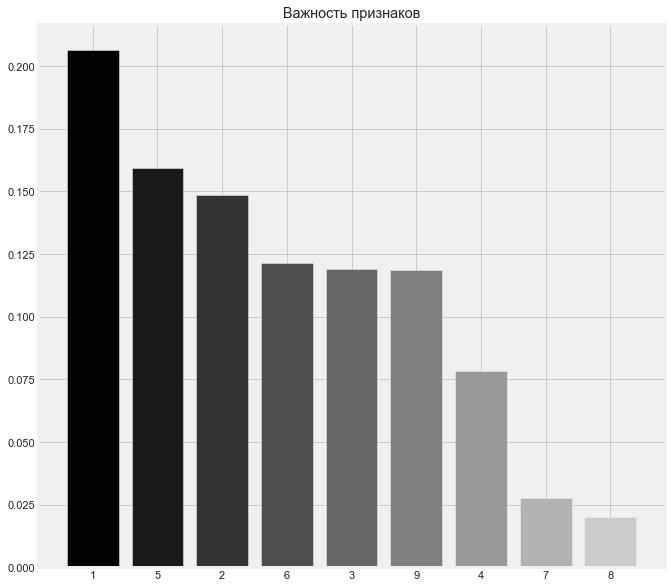

In [172]:
name=X_train.columns
importances = sel.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
# X is the train data used to fit the model 
num_to_plot = 9
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
#print("Feature ranking:")

plt.figure(figsize=(10,10))
plt.title(u"Важность признаков")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
#plt.xlim([-1, num_to_plot])
data.info()

### Произведем L1 регуляризацию

In [153]:
data = pd.read_csv('flats_moscow.csv', sep=',')
data = data.drop(['Unnamed: 0'], axis='columns')
data.head(5)
x = data.drop(['walk'], axis='columns')
y = data['walk']
X_train, X_test, y_train, y_test  =  train_test_split(x, y)

In [154]:
alphas = np.arange(0, 2, 0.01)
coefs_lasso = np.zeros((alphas.shape[0], X_train.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),

for i, a in enumerate(alphas):
    print(f'Коэффициент лямбда = {a}')
    regrL = Lasso(alpha=a)

    # Train the model using the sets
    regrL.fit(X_train, y_train)

    # The coefficients
    weights=regrL.coef_
    print('Веса признаков: \n', regrL.coef_)
    for j, weight in enumerate(weights):
        coefs_lasso[i,j]=weight

Коэффициент лямбда = 0.0
Веса признаков: 
 [ 0.00190395 -0.00649025  0.002599    0.00024716 -0.01148539 -0.00069387
  0.08589893 -0.01823495 -0.00679742]
Коэффициент лямбда = 0.01
Веса признаков: 
 [ 0.00200883 -0.00674884  0.00302427 -0.         -0.01282127 -0.
  0.03322548 -0.         -0.00432466]
Коэффициент лямбда = 0.02
Веса признаков: 
 [ 0.00210478 -0.00681594  0.00300151 -0.         -0.01306219 -0.
  0.         -0.         -0.00180121]
Коэффициент лямбда = 0.03
Веса признаков: 
 [ 0.00215503 -0.00649929  0.00218384 -0.         -0.01194959 -0.
  0.         -0.         -0.        ]
Коэффициент лямбда = 0.04
Веса признаков: 
 [ 0.00217893 -0.00612656  0.00137645 -0.         -0.01115961 -0.
  0.         -0.         -0.        ]
Коэффициент лямбда = 0.05
Веса признаков: 
 [ 0.00220278 -0.00575379  0.00056926 -0.         -0.01036983 -0.
  0.         -0.         -0.        ]
Коэффициент лямбда = 0.06
Веса признаков: 
 [ 0.00222053 -0.00547392  0.         -0.         -0.00954571 -0.
  

Веса признаков: 
 [ 0.000903 -0.       -0.       -0.       -0.       -0.        0.
 -0.       -0.      ]
Коэффициент лямбда = 0.96
Веса признаков: 
 [ 0.00089939 -0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.        ]
Коэффициент лямбда = 0.97
Веса признаков: 
 [ 0.00089578 -0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.        ]
Коэффициент лямбда = 0.98
Веса признаков: 
 [ 0.00089217 -0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.        ]
Коэффициент лямбда = 0.99
Веса признаков: 
 [ 0.00088857 -0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.        ]
Коэффициент лямбда = 1.0
Веса признаков: 
 [ 0.00088496 -0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.        ]
Коэффициент лямбда = 1.01
Веса признаков: 
 [ 0.00088135 -0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.        ]
Коэффициент ля

 [ 0.00053504 -0.          0.         -0.         -0.         -0.
  0.         -0.         -0.        ]
Коэффициент лямбда = 1.98
Веса признаков: 
 [ 0.00053143 -0.          0.         -0.         -0.         -0.
  0.         -0.         -0.        ]
Коэффициент лямбда = 1.99
Веса признаков: 
 [ 0.00052782 -0.          0.         -0.         -0.         -0.
  0.         -0.         -0.        ]


Text(0.5, 1.0, 'Lasso')

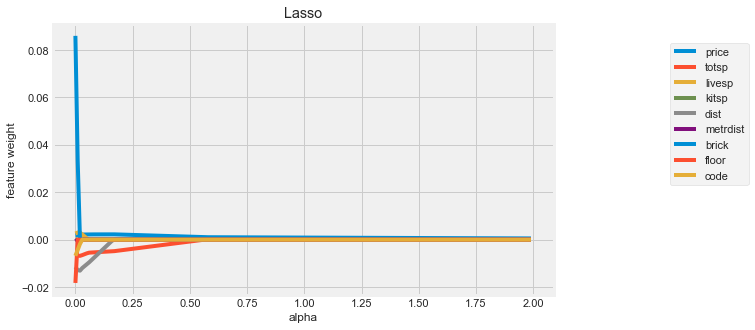

In [155]:
plt.figure(figsize=(8, 5))

colors=[]
for feature in X_train.columns:
    colors.append(np.random.rand(4))

for coef, feature, color in zip(coefs_lasso.T, X_train.columns, colors):
    plt.plot(alphas, coef, label=feature)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")


##  3. Сравним качество работы случайного леса без кросс-валидации VS  с кросс-валидацией

In [156]:
data = pd.read_csv('flats_moscow.csv', sep=',')
data = data.drop(['Unnamed: 0'], axis='columns')
data = data.drop(['totsp', 'livesp', 'kitsp'], axis='columns')
X = data.drop(['walk'], axis='columns')
y = data['walk']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,random_state=17)
#X_train, X_test, y_train, y_test  =  train_test_split(X, y, stratify=y)

In [157]:
# Создаём модель леса из сотни деревьев
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Обучаем на тренировочных данных
model.fit(X_train, y_train)

score = model.score(X_holdout, y_holdout)
print(score)

0.8006535947712419


#### Применим кросс-валидацию  над случанйм лесом

In [158]:
param_grid = {
                 'n_estimators': range(1,100),
                 'max_depth': range(1, 10)
             }
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 891 candidates, totalling 2673 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 1606 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 2496 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 2650 out of 2673 | elapsed:   51.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 2673 out of 2673 | elapsed:   52.4s finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(max_features='sqrt'),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': range(1, 100)},
             verbose=2)

In [159]:
print(grid_search.best_params_)

{'max_depth': 8, 'n_estimators': 39}


In [160]:
print(grid_search.best_score_)

0.7780112044817926


In [161]:
print (np.mean(cross_val_score(model, X_train, y_train, cv=200, scoring='precision')))

0.827095238095238


####   Построим лес на данных   кросс-валидации  

In [162]:
data = pd.read_csv('flats_moscow.csv', sep=',')
data = data.drop(['Unnamed: 0'], axis='columns')
data = data.drop(['totsp', 'livesp', 'kitsp'], axis='columns')
X = data.drop(['walk'], axis='columns')
y = data['walk']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
random_state=17)

# Создаём модель леса из сотни деревьев
model = RandomForestClassifier(n_estimators=56,
                               max_depth=9,
                               bootstrap = True,
                               max_features = 'sqrt')
# Обучаем на тренировочных данных
model.fit(X_train, y_train)

score = model.score(X_holdout, y_holdout)
print(score)

0.7810457516339869


##  4. Градиентный бустинг VS  решающие деревья
![title](image/9.jpeg)

###  Сравним  алгоритмы градиентного  бустинга  

In [163]:
data = pd.read_csv('flats_moscow.csv', sep=',')
data = data.drop(['Unnamed: 0'], axis='columns')
data.head(5)
x = data.drop(['walk'], axis='columns')
y = data['walk']
X_train, X_test, y_train, y_test  =  train_test_split(x, y)


 
# инициализация KFold с 5тью фолдами
cv = KFold(n_splits=5, random_state=42, shuffle=True)
 
classifiers = []
# метод split возвращает индексы для объектов train и test
clf = CatBoostClassifier(random_state=42, iterations=200, verbose=50, learning_rate=0.1)
clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)
score=clf.score(X_test, y_test)
print('Catboost score:'+ str(score))
 
    # получим 5 оптимальных классификаторов
classifiers.append(clf)

0:	learn: 0.6581468	test: 0.6597801	best: 0.6597801 (0)	total: 5.15ms	remaining: 1.02s
50:	learn: 0.3787236	test: 0.4622507	best: 0.4622507 (50)	total: 181ms	remaining: 528ms
100:	learn: 0.2852892	test: 0.4251946	best: 0.4251946 (100)	total: 380ms	remaining: 372ms
150:	learn: 0.2247686	test: 0.4150482	best: 0.4150482 (150)	total: 535ms	remaining: 174ms
199:	learn: 0.1793278	test: 0.4058024	best: 0.4042175 (190)	total: 673ms	remaining: 0us

bestTest = 0.4042175093
bestIteration = 190

Shrink model to first 191 iterations.
Catboost score:0.8156862745098039


In [164]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
score = xgb_clf.score(X_test, y_test)
print('xgboost score:'+ str(score))

xgboost score:0.8


###  Произведем градиентный бустинг. Сначала  на  CPU,  потом  GPU,   а  потом  случанй  лес

In [165]:
%%time

data = pd.read_csv('flats_moscow.csv', sep=',')
data = data.drop(['Unnamed: 0'], axis='columns')
data.head(5)
x = data.drop(['walk'], axis='columns')
y = data['walk']
X_train, X_test, y_train, y_test  =  train_test_split(x, y)


scores1 = np.ndarray([10, 10])
for i, n_trees in enumerate(np.linspace(1, 100, 10)):
    for j, depth in enumerate(np.arange(2, 12)):
        p = CatBoostClassifier(n_estimators=n_trees, max_depth=depth, task_type="CPU").fit(X_train, y_train).predict(X_test)
        scores1[i, j] = precision_score(y_test, p)


Learning rate set to 0.5
0:	learn: 0.6380652	total: 1.08ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6299888	total: 1.48ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6264285	total: 2.32ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6282193	total: 2.03ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6249031	total: 2.33ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6292275	total: 3.39ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6288924	total: 4.88ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6310672	total: 10.2ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6335771	total: 11.2ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6243318	total: 21.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6380652	total: 5.08ms	remaining: 55.9ms
1:	learn: 0.6051651	total: 6.36ms	remaining: 31.8ms
2:	learn: 0.5875678	total: 7.21ms	remaining: 21.6ms
3:	learn: 0.5758007	total: 8.1ms	remaining: 16.2ms
4:	learn: 0.5662855	total: 9

0:	learn: 0.6378950	total: 1.71ms	remaining: 37.6ms
1:	learn: 0.5958757	total: 3.03ms	remaining: 31.8ms
2:	learn: 0.5840322	total: 3.9ms	remaining: 26ms
3:	learn: 0.5711855	total: 5.16ms	remaining: 24.5ms
4:	learn: 0.5571011	total: 6.33ms	remaining: 22.8ms
5:	learn: 0.5483651	total: 7.6ms	remaining: 21.5ms
6:	learn: 0.5422718	total: 8.77ms	remaining: 20ms
7:	learn: 0.5344307	total: 9.97ms	remaining: 18.7ms
8:	learn: 0.5255259	total: 11.1ms	remaining: 17.3ms
9:	learn: 0.5217258	total: 12.3ms	remaining: 16ms
10:	learn: 0.5132721	total: 13.7ms	remaining: 14.9ms
11:	learn: 0.5098607	total: 14.9ms	remaining: 13.7ms
12:	learn: 0.5031368	total: 16.1ms	remaining: 12.4ms
13:	learn: 0.4945897	total: 17.4ms	remaining: 11.2ms
14:	learn: 0.4920420	total: 19ms	remaining: 10.1ms
15:	learn: 0.4820047	total: 20.1ms	remaining: 8.81ms
16:	learn: 0.4790961	total: 21.3ms	remaining: 7.53ms
17:	learn: 0.4720529	total: 22.5ms	remaining: 6.25ms
18:	learn: 0.4639233	total: 23.7ms	remaining: 4.99ms
19:	learn: 0.

Learning rate set to 0.392729
0:	learn: 0.6374723	total: 25.1ms	remaining: 553ms
1:	learn: 0.5896868	total: 56.8ms	remaining: 596ms
2:	learn: 0.5560724	total: 83.3ms	remaining: 555ms
3:	learn: 0.5265149	total: 109ms	remaining: 519ms
4:	learn: 0.5037585	total: 143ms	remaining: 517ms
5:	learn: 0.4874955	total: 178ms	remaining: 503ms
6:	learn: 0.4690300	total: 213ms	remaining: 488ms
7:	learn: 0.4546620	total: 251ms	remaining: 471ms
8:	learn: 0.4402296	total: 290ms	remaining: 451ms
9:	learn: 0.4297505	total: 334ms	remaining: 434ms
10:	learn: 0.4192459	total: 378ms	remaining: 412ms
11:	learn: 0.4099785	total: 421ms	remaining: 386ms
12:	learn: 0.3967048	total: 455ms	remaining: 350ms
13:	learn: 0.3895766	total: 498ms	remaining: 320ms
14:	learn: 0.3793317	total: 534ms	remaining: 285ms
15:	learn: 0.3738264	total: 558ms	remaining: 244ms
16:	learn: 0.3655820	total: 583ms	remaining: 206ms
17:	learn: 0.3588351	total: 621ms	remaining: 173ms
18:	learn: 0.3478208	total: 652ms	remaining: 137ms
19:	lear

0:	learn: 0.6519839	total: 11.2ms	remaining: 371ms
1:	learn: 0.6252145	total: 13ms	remaining: 207ms
2:	learn: 0.6022454	total: 15.1ms	remaining: 156ms
3:	learn: 0.5765099	total: 16.9ms	remaining: 127ms
4:	learn: 0.5643061	total: 18.7ms	remaining: 109ms
5:	learn: 0.5464188	total: 21.3ms	remaining: 99.2ms
6:	learn: 0.5341858	total: 24.5ms	remaining: 94.6ms
7:	learn: 0.5269679	total: 26.4ms	remaining: 85.9ms
8:	learn: 0.5205447	total: 28.3ms	remaining: 78.7ms
9:	learn: 0.5140626	total: 30.1ms	remaining: 72.3ms
10:	learn: 0.5035583	total: 32.1ms	remaining: 67.2ms
11:	learn: 0.4953163	total: 33.9ms	remaining: 62.2ms
12:	learn: 0.4887133	total: 36.8ms	remaining: 59.4ms
13:	learn: 0.4805769	total: 39ms	remaining: 55.7ms
14:	learn: 0.4737864	total: 41.9ms	remaining: 53.1ms
15:	learn: 0.4675233	total: 44ms	remaining: 49.5ms
16:	learn: 0.4627672	total: 46.1ms	remaining: 46.1ms
17:	learn: 0.4601884	total: 48.2ms	remaining: 42.8ms
18:	learn: 0.4550505	total: 50.1ms	remaining: 39.5ms
19:	learn: 0.4

22:	learn: 0.3797437	total: 386ms	remaining: 184ms
23:	learn: 0.3742791	total: 397ms	remaining: 166ms
24:	learn: 0.3665598	total: 417ms	remaining: 150ms
25:	learn: 0.3602630	total: 485ms	remaining: 149ms
26:	learn: 0.3550017	total: 498ms	remaining: 129ms
27:	learn: 0.3542394	total: 499ms	remaining: 107ms
28:	learn: 0.3494223	total: 513ms	remaining: 88.4ms
29:	learn: 0.3439651	total: 525ms	remaining: 70ms
30:	learn: 0.3397179	total: 538ms	remaining: 52.1ms
31:	learn: 0.3340588	total: 557ms	remaining: 34.8ms
32:	learn: 0.3312300	total: 570ms	remaining: 17.3ms
33:	learn: 0.3262029	total: 590ms	remaining: 0us
Learning rate set to 0.27443
0:	learn: 0.6529810	total: 31.2ms	remaining: 1.03s
1:	learn: 0.6160782	total: 56.6ms	remaining: 906ms
2:	learn: 0.5892332	total: 89.7ms	remaining: 927ms
3:	learn: 0.5673475	total: 116ms	remaining: 873ms
4:	learn: 0.5452120	total: 146ms	remaining: 844ms
5:	learn: 0.5269557	total: 175ms	remaining: 819ms
6:	learn: 0.5111888	total: 206ms	remaining: 793ms
7:	le

Learning rate set to 0.212227
0:	learn: 0.6618860	total: 1.84ms	remaining: 81.1ms
1:	learn: 0.6369608	total: 3.27ms	remaining: 70.3ms
2:	learn: 0.6141566	total: 4.73ms	remaining: 66.2ms
3:	learn: 0.5999088	total: 6.21ms	remaining: 63.7ms
4:	learn: 0.5888895	total: 7.63ms	remaining: 61.1ms
5:	learn: 0.5793427	total: 9.18ms	remaining: 59.7ms
6:	learn: 0.5700777	total: 10.6ms	remaining: 57.5ms
7:	learn: 0.5578533	total: 12ms	remaining: 55.5ms
8:	learn: 0.5489271	total: 13.4ms	remaining: 53.8ms
9:	learn: 0.5407128	total: 14.9ms	remaining: 52.2ms
10:	learn: 0.5343752	total: 16.3ms	remaining: 50.5ms
11:	learn: 0.5290687	total: 17.9ms	remaining: 49.1ms
12:	learn: 0.5251688	total: 19.4ms	remaining: 47.8ms
13:	learn: 0.5212869	total: 20.9ms	remaining: 46.3ms
14:	learn: 0.5171009	total: 22.3ms	remaining: 44.6ms
15:	learn: 0.5125121	total: 24.2ms	remaining: 43.8ms
16:	learn: 0.5099081	total: 26.6ms	remaining: 43.8ms
17:	learn: 0.5047368	total: 28ms	remaining: 42.1ms
18:	learn: 0.5002893	total: 29

23:	learn: 0.4336672	total: 80.7ms	remaining: 70.6ms
24:	learn: 0.4290763	total: 83.9ms	remaining: 67.1ms
25:	learn: 0.4247841	total: 87ms	remaining: 63.6ms
26:	learn: 0.4215079	total: 90.2ms	remaining: 60.1ms
27:	learn: 0.4196433	total: 93.3ms	remaining: 56.7ms
28:	learn: 0.4165985	total: 96.7ms	remaining: 53.4ms
29:	learn: 0.4129323	total: 100ms	remaining: 50.1ms
30:	learn: 0.4091006	total: 103ms	remaining: 46.7ms
31:	learn: 0.4044538	total: 106ms	remaining: 43.3ms
32:	learn: 0.4008361	total: 110ms	remaining: 39.9ms
33:	learn: 0.3987260	total: 113ms	remaining: 36.6ms
34:	learn: 0.3956748	total: 116ms	remaining: 33.3ms
35:	learn: 0.3908014	total: 120ms	remaining: 29.9ms
36:	learn: 0.3890613	total: 123ms	remaining: 26.6ms
37:	learn: 0.3851842	total: 126ms	remaining: 23.3ms
38:	learn: 0.3815275	total: 130ms	remaining: 19.9ms
39:	learn: 0.3783389	total: 133ms	remaining: 16.6ms
40:	learn: 0.3745480	total: 136ms	remaining: 13.3ms
41:	learn: 0.3723929	total: 139ms	remaining: 9.95ms
42:	lear

38:	learn: 0.4968878	total: 42.1ms	remaining: 18.4ms
39:	learn: 0.4946176	total: 43.2ms	remaining: 17.3ms
40:	learn: 0.4930873	total: 44.2ms	remaining: 16.2ms
41:	learn: 0.4927441	total: 45.3ms	remaining: 15.1ms
42:	learn: 0.4881270	total: 46.3ms	remaining: 14ms
43:	learn: 0.4868470	total: 47.5ms	remaining: 13ms
44:	learn: 0.4857960	total: 48.5ms	remaining: 11.9ms
45:	learn: 0.4827950	total: 49.7ms	remaining: 10.8ms
46:	learn: 0.4814000	total: 50.7ms	remaining: 9.71ms
47:	learn: 0.4786832	total: 51.9ms	remaining: 8.65ms
48:	learn: 0.4769151	total: 52.9ms	remaining: 7.56ms
49:	learn: 0.4751079	total: 53.9ms	remaining: 6.47ms
50:	learn: 0.4736401	total: 54.9ms	remaining: 5.38ms
51:	learn: 0.4715559	total: 56.1ms	remaining: 4.31ms
52:	learn: 0.4697635	total: 57.1ms	remaining: 3.23ms
53:	learn: 0.4680127	total: 58.1ms	remaining: 2.15ms
54:	learn: 0.4661238	total: 59.2ms	remaining: 1.07ms
55:	learn: 0.4642816	total: 60.4ms	remaining: 0us
Learning rate set to 0.173664
0:	learn: 0.6661062	tot

11:	learn: 0.5167905	total: 29.9ms	remaining: 110ms
12:	learn: 0.5107170	total: 32.4ms	remaining: 107ms
13:	learn: 0.5061538	total: 35.2ms	remaining: 106ms
14:	learn: 0.5010469	total: 37.9ms	remaining: 104ms
15:	learn: 0.4971164	total: 40.4ms	remaining: 101ms
16:	learn: 0.4909910	total: 42.7ms	remaining: 97.9ms
17:	learn: 0.4862120	total: 44.9ms	remaining: 94.7ms
18:	learn: 0.4812328	total: 47.3ms	remaining: 92.1ms
19:	learn: 0.4784689	total: 49.9ms	remaining: 89.8ms
20:	learn: 0.4764551	total: 52.4ms	remaining: 87.3ms
21:	learn: 0.4712719	total: 54.9ms	remaining: 84.8ms
22:	learn: 0.4678014	total: 57.6ms	remaining: 82.7ms
23:	learn: 0.4647849	total: 60ms	remaining: 80ms
24:	learn: 0.4604920	total: 62.2ms	remaining: 77.1ms
25:	learn: 0.4577687	total: 64.6ms	remaining: 74.5ms
26:	learn: 0.4528453	total: 66.9ms	remaining: 71.9ms
27:	learn: 0.4493003	total: 69.2ms	remaining: 69.2ms
28:	learn: 0.4468350	total: 71.4ms	remaining: 66.5ms
29:	learn: 0.4435463	total: 73.9ms	remaining: 64.1ms
30

16:	learn: 0.4750337	total: 181ms	remaining: 415ms
17:	learn: 0.4708809	total: 193ms	remaining: 407ms
18:	learn: 0.4648009	total: 203ms	remaining: 396ms
19:	learn: 0.4585504	total: 214ms	remaining: 385ms
20:	learn: 0.4544453	total: 225ms	remaining: 374ms
21:	learn: 0.4470503	total: 235ms	remaining: 363ms
22:	learn: 0.4411745	total: 246ms	remaining: 353ms
23:	learn: 0.4361020	total: 258ms	remaining: 344ms
24:	learn: 0.4324539	total: 269ms	remaining: 334ms
25:	learn: 0.4296525	total: 280ms	remaining: 323ms
26:	learn: 0.4239136	total: 292ms	remaining: 313ms
27:	learn: 0.4191155	total: 303ms	remaining: 303ms
28:	learn: 0.4155720	total: 315ms	remaining: 293ms
29:	learn: 0.4100941	total: 328ms	remaining: 284ms
30:	learn: 0.4054823	total: 339ms	remaining: 273ms
31:	learn: 0.4017341	total: 351ms	remaining: 263ms
32:	learn: 0.3969418	total: 362ms	remaining: 252ms
33:	learn: 0.3945444	total: 372ms	remaining: 241ms
34:	learn: 0.3892156	total: 385ms	remaining: 231ms
35:	learn: 0.3854515	total: 397

42:	learn: 0.4999668	total: 43.9ms	remaining: 24.5ms
43:	learn: 0.4982582	total: 44.9ms	remaining: 23.5ms
44:	learn: 0.4970630	total: 46ms	remaining: 22.5ms
45:	learn: 0.4949060	total: 46.9ms	remaining: 21.4ms
46:	learn: 0.4939907	total: 47.9ms	remaining: 20.4ms
47:	learn: 0.4921117	total: 48.9ms	remaining: 19.4ms
48:	learn: 0.4903851	total: 49.9ms	remaining: 18.3ms
49:	learn: 0.4892486	total: 50.9ms	remaining: 17.3ms
50:	learn: 0.4888693	total: 51.9ms	remaining: 16.3ms
51:	learn: 0.4864259	total: 52.9ms	remaining: 15.2ms
52:	learn: 0.4850686	total: 53.8ms	remaining: 14.2ms
53:	learn: 0.4834349	total: 54.8ms	remaining: 13.2ms
54:	learn: 0.4813186	total: 55.8ms	remaining: 12.2ms
55:	learn: 0.4789245	total: 56.8ms	remaining: 11.1ms
56:	learn: 0.4769627	total: 57.8ms	remaining: 10.1ms
57:	learn: 0.4750355	total: 58.8ms	remaining: 9.12ms
58:	learn: 0.4733568	total: 59.7ms	remaining: 8.1ms
59:	learn: 0.4726449	total: 60.7ms	remaining: 7.08ms
60:	learn: 0.4708241	total: 61.9ms	remaining: 6.0

1:	learn: 0.6518318	total: 4.41ms	remaining: 143ms
2:	learn: 0.6341683	total: 6.15ms	remaining: 131ms
3:	learn: 0.6211154	total: 7.98ms	remaining: 126ms
4:	learn: 0.6115695	total: 9.77ms	remaining: 121ms
5:	learn: 0.6033074	total: 11.5ms	remaining: 117ms
6:	learn: 0.5899761	total: 13.3ms	remaining: 114ms
7:	learn: 0.5825748	total: 15.3ms	remaining: 113ms
8:	learn: 0.5764252	total: 17.1ms	remaining: 110ms
9:	learn: 0.5680730	total: 18.9ms	remaining: 108ms
10:	learn: 0.5618283	total: 20.6ms	remaining: 105ms
11:	learn: 0.5513114	total: 22.6ms	remaining: 103ms
12:	learn: 0.5437773	total: 24.4ms	remaining: 101ms
13:	learn: 0.5384350	total: 26.5ms	remaining: 100ms
14:	learn: 0.5333650	total: 28.4ms	remaining: 98.4ms
15:	learn: 0.5298319	total: 30.2ms	remaining: 96.3ms
16:	learn: 0.5247782	total: 32.1ms	remaining: 94.5ms
17:	learn: 0.5207352	total: 33.9ms	remaining: 92.4ms
18:	learn: 0.5138795	total: 35.7ms	remaining: 90.2ms
19:	learn: 0.5089329	total: 37.4ms	remaining: 88ms
20:	learn: 0.5041

39:	learn: 0.4166582	total: 132ms	remaining: 89.1ms
40:	learn: 0.4144277	total: 135ms	remaining: 85.7ms
41:	learn: 0.4117657	total: 138ms	remaining: 82.3ms
42:	learn: 0.4097925	total: 142ms	remaining: 79.2ms
43:	learn: 0.4071621	total: 145ms	remaining: 75.8ms
44:	learn: 0.4043223	total: 148ms	remaining: 72.4ms
45:	learn: 0.4012834	total: 151ms	remaining: 69.1ms
46:	learn: 0.3983475	total: 155ms	remaining: 65.8ms
47:	learn: 0.3963193	total: 158ms	remaining: 62.6ms
48:	learn: 0.3945825	total: 161ms	remaining: 59.3ms
49:	learn: 0.3930838	total: 165ms	remaining: 55.9ms
50:	learn: 0.3908130	total: 168ms	remaining: 52.7ms
51:	learn: 0.3882718	total: 171ms	remaining: 49.4ms
52:	learn: 0.3852573	total: 174ms	remaining: 46.1ms
53:	learn: 0.3829710	total: 178ms	remaining: 42.7ms
54:	learn: 0.3790339	total: 181ms	remaining: 39.5ms
55:	learn: 0.3762472	total: 184ms	remaining: 36.2ms
56:	learn: 0.3739368	total: 188ms	remaining: 32.9ms
57:	learn: 0.3723004	total: 191ms	remaining: 29.7ms
58:	learn: 0

Learning rate set to 0.147328
0:	learn: 0.6708513	total: 22.6ms	remaining: 1.49s
1:	learn: 0.6487567	total: 47.5ms	remaining: 1.54s
2:	learn: 0.6290241	total: 69.1ms	remaining: 1.47s
3:	learn: 0.6102450	total: 89.4ms	remaining: 1.41s
4:	learn: 0.5928530	total: 113ms	remaining: 1.4s
5:	learn: 0.5800433	total: 123ms	remaining: 1.25s
6:	learn: 0.5656287	total: 146ms	remaining: 1.25s
7:	learn: 0.5535583	total: 167ms	remaining: 1.23s
8:	learn: 0.5453145	total: 169ms	remaining: 1.09s
9:	learn: 0.5362155	total: 189ms	remaining: 1.08s
10:	learn: 0.5291335	total: 213ms	remaining: 1.08s
11:	learn: 0.5198309	total: 235ms	remaining: 1.08s
12:	learn: 0.5128204	total: 255ms	remaining: 1.06s
13:	learn: 0.5091467	total: 256ms	remaining: 969ms
14:	learn: 0.5028473	total: 280ms	remaining: 971ms
15:	learn: 0.4965805	total: 301ms	remaining: 959ms
16:	learn: 0.4890838	total: 321ms	remaining: 943ms
17:	learn: 0.4829115	total: 342ms	remaining: 932ms
18:	learn: 0.4763470	total: 362ms	remaining: 914ms
19:	lear

28:	learn: 0.5356880	total: 29.7ms	remaining: 50.2ms
29:	learn: 0.5342278	total: 30.7ms	remaining: 49.2ms
30:	learn: 0.5323790	total: 31.9ms	remaining: 48.4ms
31:	learn: 0.5299038	total: 32.9ms	remaining: 47.3ms
32:	learn: 0.5278655	total: 33.9ms	remaining: 46.2ms
33:	learn: 0.5260780	total: 34.9ms	remaining: 45.2ms
34:	learn: 0.5244216	total: 35.9ms	remaining: 44.1ms
35:	learn: 0.5231353	total: 37ms	remaining: 43.1ms
36:	learn: 0.5207739	total: 38.3ms	remaining: 42.4ms
37:	learn: 0.5165157	total: 39.2ms	remaining: 41.3ms
38:	learn: 0.5149431	total: 40.2ms	remaining: 40.2ms
39:	learn: 0.5132272	total: 41.2ms	remaining: 39.1ms
40:	learn: 0.5119478	total: 42.2ms	remaining: 38.1ms
41:	learn: 0.5101491	total: 43.4ms	remaining: 37.2ms
42:	learn: 0.5067243	total: 44.4ms	remaining: 36.2ms
43:	learn: 0.5049322	total: 45.6ms	remaining: 35.2ms
44:	learn: 0.5036607	total: 46.6ms	remaining: 34.2ms
45:	learn: 0.5023767	total: 47.5ms	remaining: 33.1ms
46:	learn: 0.5015085	total: 48.5ms	remaining: 32

49:	learn: 0.4520894	total: 76.6ms	remaining: 42.9ms
50:	learn: 0.4491913	total: 78.1ms	remaining: 41.4ms
51:	learn: 0.4471758	total: 79.7ms	remaining: 39.8ms
52:	learn: 0.4458170	total: 81ms	remaining: 38.2ms
53:	learn: 0.4439605	total: 83.3ms	remaining: 37ms
54:	learn: 0.4422583	total: 84.7ms	remaining: 35.4ms
55:	learn: 0.4419757	total: 86.3ms	remaining: 33.9ms
56:	learn: 0.4409211	total: 87.7ms	remaining: 32.3ms
57:	learn: 0.4393426	total: 89.3ms	remaining: 30.8ms
58:	learn: 0.4376897	total: 90.7ms	remaining: 29.2ms
59:	learn: 0.4364480	total: 92.1ms	remaining: 27.6ms
60:	learn: 0.4356753	total: 93.5ms	remaining: 26.1ms
61:	learn: 0.4331516	total: 94.9ms	remaining: 24.5ms
62:	learn: 0.4303524	total: 96.3ms	remaining: 22.9ms
63:	learn: 0.4293457	total: 98ms	remaining: 21.4ms
64:	learn: 0.4272394	total: 99.4ms	remaining: 19.9ms
65:	learn: 0.4254408	total: 101ms	remaining: 18.3ms
66:	learn: 0.4237559	total: 102ms	remaining: 16.8ms
67:	learn: 0.4233239	total: 107ms	remaining: 15.7ms
68

Learning rate set to 0.128158
0:	learn: 0.6745619	total: 3.86ms	remaining: 298ms
1:	learn: 0.6545429	total: 7.07ms	remaining: 269ms
2:	learn: 0.6332310	total: 10.3ms	remaining: 258ms
3:	learn: 0.6166379	total: 13.5ms	remaining: 250ms
4:	learn: 0.6054771	total: 14.7ms	remaining: 215ms
5:	learn: 0.5947227	total: 17.9ms	remaining: 214ms
6:	learn: 0.5863172	total: 21ms	remaining: 213ms
7:	learn: 0.5758681	total: 24.1ms	remaining: 211ms
8:	learn: 0.5673674	total: 27.7ms	remaining: 212ms
9:	learn: 0.5597780	total: 30.9ms	remaining: 210ms
10:	learn: 0.5524466	total: 33.9ms	remaining: 207ms
11:	learn: 0.5469161	total: 37.1ms	remaining: 204ms
12:	learn: 0.5402061	total: 40.3ms	remaining: 201ms
13:	learn: 0.5364510	total: 43.4ms	remaining: 198ms
14:	learn: 0.5281691	total: 46.6ms	remaining: 196ms
15:	learn: 0.5221760	total: 49.8ms	remaining: 193ms
16:	learn: 0.5175239	total: 53.2ms	remaining: 191ms
17:	learn: 0.5140413	total: 56.6ms	remaining: 189ms
18:	learn: 0.5102496	total: 60ms	remaining: 18

20:	learn: 0.4901371	total: 189ms	remaining: 513ms
21:	learn: 0.4856857	total: 200ms	remaining: 508ms
22:	learn: 0.4794206	total: 210ms	remaining: 503ms
23:	learn: 0.4746749	total: 221ms	remaining: 498ms
24:	learn: 0.4689259	total: 232ms	remaining: 492ms
25:	learn: 0.4643840	total: 244ms	remaining: 487ms
26:	learn: 0.4587051	total: 256ms	remaining: 484ms
27:	learn: 0.4561571	total: 260ms	remaining: 463ms
28:	learn: 0.4512407	total: 271ms	remaining: 458ms
29:	learn: 0.4465348	total: 282ms	remaining: 451ms
30:	learn: 0.4420723	total: 293ms	remaining: 444ms
31:	learn: 0.4378959	total: 304ms	remaining: 438ms
32:	learn: 0.4350529	total: 316ms	remaining: 431ms
33:	learn: 0.4321967	total: 326ms	remaining: 422ms
34:	learn: 0.4292812	total: 336ms	remaining: 413ms
35:	learn: 0.4270948	total: 347ms	remaining: 405ms
36:	learn: 0.4232202	total: 358ms	remaining: 396ms
37:	learn: 0.4190649	total: 370ms	remaining: 389ms
38:	learn: 0.4157952	total: 381ms	remaining: 381ms
39:	learn: 0.4119929	total: 391

Learning rate set to 0.113555
0:	learn: 0.6757580	total: 1.29ms	remaining: 113ms
1:	learn: 0.6581685	total: 2.25ms	remaining: 98.1ms
2:	learn: 0.6443417	total: 3.23ms	remaining: 92.6ms
3:	learn: 0.6325240	total: 4.2ms	remaining: 89.3ms
4:	learn: 0.6245845	total: 5.17ms	remaining: 86.8ms
5:	learn: 0.6173552	total: 6.1ms	remaining: 84.4ms
6:	learn: 0.6088873	total: 7.07ms	remaining: 82.9ms
7:	learn: 0.6011654	total: 8.02ms	remaining: 81.3ms
8:	learn: 0.5972135	total: 8.97ms	remaining: 79.8ms
9:	learn: 0.5920798	total: 9.97ms	remaining: 78.7ms
10:	learn: 0.5870093	total: 10.9ms	remaining: 77.4ms
11:	learn: 0.5828407	total: 11.9ms	remaining: 76.4ms
12:	learn: 0.5784580	total: 13.3ms	remaining: 77.7ms
13:	learn: 0.5747608	total: 14.4ms	remaining: 77ms
14:	learn: 0.5702221	total: 15.3ms	remaining: 75.7ms
15:	learn: 0.5673210	total: 16.3ms	remaining: 74.5ms
16:	learn: 0.5648629	total: 17.3ms	remaining: 73.3ms
17:	learn: 0.5618457	total: 18.3ms	remaining: 72.1ms
18:	learn: 0.5593775	total: 19.

25:	learn: 0.5180964	total: 37.7ms	remaining: 91.3ms
26:	learn: 0.5157923	total: 39.2ms	remaining: 90ms
27:	learn: 0.5131158	total: 40.5ms	remaining: 88.3ms
28:	learn: 0.5103272	total: 41.9ms	remaining: 86.7ms
29:	learn: 0.5070303	total: 43.3ms	remaining: 85.1ms
30:	learn: 0.5043842	total: 44.6ms	remaining: 83.5ms
31:	learn: 0.5024162	total: 46ms	remaining: 82ms
32:	learn: 0.4995827	total: 47.4ms	remaining: 80.5ms
33:	learn: 0.4973731	total: 48.7ms	remaining: 78.9ms
34:	learn: 0.4955486	total: 50.1ms	remaining: 77.3ms
35:	learn: 0.4910668	total: 51.5ms	remaining: 75.8ms
36:	learn: 0.4890906	total: 52.9ms	remaining: 74.3ms
37:	learn: 0.4871913	total: 54.3ms	remaining: 72.8ms
38:	learn: 0.4851825	total: 55.6ms	remaining: 71.3ms
39:	learn: 0.4839334	total: 57ms	remaining: 69.9ms
40:	learn: 0.4824248	total: 58.4ms	remaining: 68.3ms
41:	learn: 0.4801127	total: 59.8ms	remaining: 66.9ms
42:	learn: 0.4775612	total: 61.1ms	remaining: 65.4ms
43:	learn: 0.4759825	total: 62.5ms	remaining: 63.9ms
4

5:	learn: 0.6082513	total: 14.3ms	remaining: 198ms
6:	learn: 0.5972666	total: 16.7ms	remaining: 196ms
7:	learn: 0.5867053	total: 19ms	remaining: 192ms
8:	learn: 0.5781194	total: 21.3ms	remaining: 189ms
9:	learn: 0.5691378	total: 23.6ms	remaining: 186ms
10:	learn: 0.5625654	total: 25.8ms	remaining: 183ms
11:	learn: 0.5563550	total: 28.1ms	remaining: 181ms
12:	learn: 0.5505932	total: 30.3ms	remaining: 177ms
13:	learn: 0.5443000	total: 32.7ms	remaining: 175ms
14:	learn: 0.5391308	total: 34.9ms	remaining: 172ms
15:	learn: 0.5354776	total: 37.4ms	remaining: 171ms
16:	learn: 0.5328037	total: 39.7ms	remaining: 168ms
17:	learn: 0.5284929	total: 41.9ms	remaining: 165ms
18:	learn: 0.5234985	total: 44.3ms	remaining: 163ms
19:	learn: 0.5206778	total: 46.5ms	remaining: 160ms
20:	learn: 0.5154185	total: 48.8ms	remaining: 158ms
21:	learn: 0.5121045	total: 51.1ms	remaining: 156ms
22:	learn: 0.5086135	total: 53.4ms	remaining: 153ms
23:	learn: 0.5052413	total: 55.7ms	remaining: 151ms
24:	learn: 0.501709

81:	learn: 0.3588830	total: 268ms	remaining: 22.9ms
82:	learn: 0.3565397	total: 271ms	remaining: 19.6ms
83:	learn: 0.3545781	total: 274ms	remaining: 16.3ms
84:	learn: 0.3528389	total: 278ms	remaining: 13.1ms
85:	learn: 0.3509241	total: 281ms	remaining: 9.79ms
86:	learn: 0.3489861	total: 284ms	remaining: 6.53ms
87:	learn: 0.3475033	total: 287ms	remaining: 3.26ms
88:	learn: 0.3464171	total: 290ms	remaining: 0us
Learning rate set to 0.113555
0:	learn: 0.6774104	total: 6.87ms	remaining: 604ms
1:	learn: 0.6617048	total: 12.1ms	remaining: 525ms
2:	learn: 0.6444604	total: 17.1ms	remaining: 491ms
3:	learn: 0.6290596	total: 22.1ms	remaining: 470ms
4:	learn: 0.6190644	total: 27.1ms	remaining: 456ms
5:	learn: 0.6082250	total: 32.1ms	remaining: 444ms
6:	learn: 0.5994607	total: 33.6ms	remaining: 393ms
7:	learn: 0.5881837	total: 38.5ms	remaining: 390ms
8:	learn: 0.5806156	total: 40.5ms	remaining: 360ms
9:	learn: 0.5732473	total: 45.2ms	remaining: 357ms
10:	learn: 0.5656649	total: 50.3ms	remaining: 3

74:	learn: 0.3458702	total: 808ms	remaining: 151ms
75:	learn: 0.3434654	total: 819ms	remaining: 140ms
76:	learn: 0.3421442	total: 831ms	remaining: 129ms
77:	learn: 0.3399953	total: 842ms	remaining: 119ms
78:	learn: 0.3374396	total: 853ms	remaining: 108ms
79:	learn: 0.3351936	total: 864ms	remaining: 97.2ms
80:	learn: 0.3329582	total: 875ms	remaining: 86.4ms
81:	learn: 0.3307527	total: 886ms	remaining: 75.7ms
82:	learn: 0.3288229	total: 898ms	remaining: 64.9ms
83:	learn: 0.3271608	total: 909ms	remaining: 54.1ms
84:	learn: 0.3250048	total: 920ms	remaining: 43.3ms
85:	learn: 0.3234279	total: 932ms	remaining: 32.5ms
86:	learn: 0.3218530	total: 943ms	remaining: 21.7ms
87:	learn: 0.3202405	total: 955ms	remaining: 10.8ms
88:	learn: 0.3182856	total: 966ms	remaining: 0us
Learning rate set to 0.113555
0:	learn: 0.6758118	total: 22.9ms	remaining: 2.01s
1:	learn: 0.6582780	total: 46.2ms	remaining: 2.01s
2:	learn: 0.6422220	total: 68.8ms	remaining: 1.97s
3:	learn: 0.6265478	total: 89.6ms	remaining: 

89:	learn: 0.5053482	total: 77.5ms	remaining: 8.61ms
90:	learn: 0.5046950	total: 78.3ms	remaining: 7.75ms
91:	learn: 0.5039616	total: 79.2ms	remaining: 6.89ms
92:	learn: 0.5029616	total: 80.1ms	remaining: 6.03ms
93:	learn: 0.5024044	total: 81ms	remaining: 5.17ms
94:	learn: 0.5013256	total: 81.8ms	remaining: 4.3ms
95:	learn: 0.5008389	total: 82.6ms	remaining: 3.44ms
96:	learn: 0.5001169	total: 83.6ms	remaining: 2.59ms
97:	learn: 0.4998777	total: 84.5ms	remaining: 1.72ms
98:	learn: 0.4989370	total: 85.4ms	remaining: 862us
99:	learn: 0.4986337	total: 86.2ms	remaining: 0us
Learning rate set to 0.102046
0:	learn: 0.6774376	total: 1.57ms	remaining: 155ms
1:	learn: 0.6612946	total: 2.53ms	remaining: 124ms
2:	learn: 0.6483730	total: 3.5ms	remaining: 113ms
3:	learn: 0.6371695	total: 4.44ms	remaining: 106ms
4:	learn: 0.6294425	total: 5.43ms	remaining: 103ms
5:	learn: 0.6223169	total: 6.38ms	remaining: 99.9ms
6:	learn: 0.6140594	total: 7.38ms	remaining: 98ms
7:	learn: 0.6064566	total: 8.37ms	rema

88:	learn: 0.4448377	total: 106ms	remaining: 13ms
89:	learn: 0.4441783	total: 107ms	remaining: 11.9ms
90:	learn: 0.4431640	total: 108ms	remaining: 10.7ms
91:	learn: 0.4426780	total: 109ms	remaining: 9.49ms
92:	learn: 0.4418159	total: 110ms	remaining: 8.3ms
93:	learn: 0.4410149	total: 111ms	remaining: 7.11ms
94:	learn: 0.4399362	total: 113ms	remaining: 5.93ms
95:	learn: 0.4389522	total: 114ms	remaining: 4.74ms
96:	learn: 0.4387051	total: 115ms	remaining: 3.56ms
97:	learn: 0.4382041	total: 116ms	remaining: 2.37ms
98:	learn: 0.4371445	total: 117ms	remaining: 1.19ms
99:	learn: 0.4360069	total: 119ms	remaining: 0us
Learning rate set to 0.102046
0:	learn: 0.6774258	total: 1.8ms	remaining: 178ms
1:	learn: 0.6627400	total: 3.13ms	remaining: 153ms
2:	learn: 0.6504768	total: 4.53ms	remaining: 147ms
3:	learn: 0.6394481	total: 5.91ms	remaining: 142ms
4:	learn: 0.6301648	total: 7.29ms	remaining: 139ms
5:	learn: 0.6218484	total: 8.83ms	remaining: 138ms
6:	learn: 0.6139481	total: 10.2ms	remaining: 13

0:	learn: 0.6781257	total: 3.04ms	remaining: 301ms
1:	learn: 0.6626809	total: 5.33ms	remaining: 261ms
2:	learn: 0.6481371	total: 7.67ms	remaining: 248ms
3:	learn: 0.6375832	total: 10.2ms	remaining: 245ms
4:	learn: 0.6281150	total: 12.6ms	remaining: 239ms
5:	learn: 0.6145728	total: 14.9ms	remaining: 234ms
6:	learn: 0.6040672	total: 17.2ms	remaining: 229ms
7:	learn: 0.5939355	total: 19.5ms	remaining: 224ms
8:	learn: 0.5855873	total: 21.8ms	remaining: 220ms
9:	learn: 0.5769884	total: 24.3ms	remaining: 219ms
10:	learn: 0.5706098	total: 26.7ms	remaining: 216ms
11:	learn: 0.5644294	total: 29ms	remaining: 213ms
12:	learn: 0.5585884	total: 31.3ms	remaining: 210ms
13:	learn: 0.5523922	total: 34.1ms	remaining: 209ms
14:	learn: 0.5472379	total: 36.4ms	remaining: 206ms
15:	learn: 0.5434955	total: 38.8ms	remaining: 204ms
16:	learn: 0.5411464	total: 41.1ms	remaining: 201ms
17:	learn: 0.5369347	total: 43.4ms	remaining: 198ms
18:	learn: 0.5319704	total: 45.7ms	remaining: 195ms
19:	learn: 0.5290815	tot

99:	learn: 0.3519577	total: 349ms	remaining: 0us
Learning rate set to 0.102046
0:	learn: 0.6789612	total: 6.21ms	remaining: 615ms
1:	learn: 0.6646507	total: 11.8ms	remaining: 578ms
2:	learn: 0.6488496	total: 17.3ms	remaining: 559ms
3:	learn: 0.6330845	total: 22.4ms	remaining: 537ms
4:	learn: 0.6236551	total: 27.9ms	remaining: 529ms
5:	learn: 0.6135035	total: 32.9ms	remaining: 515ms
6:	learn: 0.6050530	total: 34.3ms	remaining: 455ms
7:	learn: 0.5943155	total: 39.3ms	remaining: 452ms
8:	learn: 0.5869512	total: 41.1ms	remaining: 415ms
9:	learn: 0.5797024	total: 45.9ms	remaining: 413ms
10:	learn: 0.5730034	total: 50.9ms	remaining: 412ms
11:	learn: 0.5684466	total: 56.1ms	remaining: 411ms
12:	learn: 0.5644278	total: 61.1ms	remaining: 409ms
13:	learn: 0.5603729	total: 62.2ms	remaining: 382ms
14:	learn: 0.5544308	total: 67.3ms	remaining: 381ms
15:	learn: 0.5470580	total: 72.2ms	remaining: 379ms
16:	learn: 0.5404333	total: 77.2ms	remaining: 377ms
17:	learn: 0.5337618	total: 82.4ms	remaining: 3

64:	learn: 0.3800094	total: 784ms	remaining: 422ms
65:	learn: 0.3779134	total: 795ms	remaining: 410ms
66:	learn: 0.3757447	total: 807ms	remaining: 398ms
67:	learn: 0.3738532	total: 820ms	remaining: 386ms
68:	learn: 0.3718729	total: 831ms	remaining: 374ms
69:	learn: 0.3701641	total: 843ms	remaining: 361ms
70:	learn: 0.3676274	total: 856ms	remaining: 349ms
71:	learn: 0.3665573	total: 868ms	remaining: 338ms
72:	learn: 0.3648325	total: 881ms	remaining: 326ms
73:	learn: 0.3631434	total: 893ms	remaining: 314ms
74:	learn: 0.3609525	total: 905ms	remaining: 302ms
75:	learn: 0.3589328	total: 919ms	remaining: 290ms
76:	learn: 0.3573018	total: 931ms	remaining: 278ms
77:	learn: 0.3555576	total: 943ms	remaining: 266ms
78:	learn: 0.3533991	total: 956ms	remaining: 254ms
79:	learn: 0.3519107	total: 967ms	remaining: 242ms
80:	learn: 0.3494799	total: 980ms	remaining: 230ms
81:	learn: 0.3469694	total: 992ms	remaining: 218ms
82:	learn: 0.3458113	total: 1s	remaining: 206ms
83:	learn: 0.3434975	total: 1.02s	

In [166]:
%%time
data = pd.read_csv('flats_moscow.csv', sep=',')
data = data.drop(['Unnamed: 0'], axis='columns')
data.head(5)
x = data.drop(['walk'], axis='columns')
y = data['walk']
X_train, X_test, y_train, y_test  =  train_test_split(x, y)


scores = np.ndarray([10, 10])
for i, n_trees in enumerate(np.linspace(1, 100, 10)): #Функция linspace() возвращает одномерный массив из указанного количества элементов, значения которых равномерно распределенны внутри заданного интервала. 
    for j, depth in enumerate(np.arange(2, 12)): #Функция arange() возвращает одномерный массив с равномерно разнесенными значениями внутри заданного интервала в данном случае от 2 до 11.
        p = CatBoostClassifier(n_estimators=n_trees, max_depth=depth, task_type="GPU").fit(X_train, y_train).predict(X_test)
        scores[i, j] =  precision_score(y_test, p)
        

Learning rate set to 0.5
0:	learn: 0.6232313	total: 10.2ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6215874	total: 7.2ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6216106	total: 10.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6164004	total: 12.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6120581	total: 15.4ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6106097	total: 13.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6050470	total: 18.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6096218	total: 19.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6086672	total: 17.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6164377	total: 20.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6232313	total: 11.2ms	remaining: 124ms
1:	learn: 0.6005156	total: 17ms	remaining: 85ms
2:	learn: 0.5828275	total: 22.5ms	remaining: 67.5ms
3:	learn: 0.5713401	total: 27.5ms	remaining: 54.9ms
4:	learn: 0.5590324	total: 34.1ms

Learning rate set to 0.5
0:	learn: 0.6215874	total: 12.7ms	remaining: 278ms
1:	learn: 0.5854712	total: 21.2ms	remaining: 222ms
2:	learn: 0.5699877	total: 28.1ms	remaining: 188ms
3:	learn: 0.5552621	total: 34.6ms	remaining: 164ms
4:	learn: 0.5436591	total: 42.3ms	remaining: 152ms
5:	learn: 0.5335326	total: 48.5ms	remaining: 137ms
6:	learn: 0.5250868	total: 55.5ms	remaining: 127ms
7:	learn: 0.5178669	total: 62.9ms	remaining: 118ms
8:	learn: 0.5116667	total: 68.9ms	remaining: 107ms
9:	learn: 0.5074920	total: 75.6ms	remaining: 98.3ms
10:	learn: 0.4970683	total: 82.4ms	remaining: 89.9ms
11:	learn: 0.4919004	total: 88.9ms	remaining: 81.5ms
12:	learn: 0.4860186	total: 95.1ms	remaining: 73.2ms
13:	learn: 0.4800463	total: 101ms	remaining: 65ms
14:	learn: 0.4734463	total: 108ms	remaining: 57.6ms
15:	learn: 0.4696764	total: 115ms	remaining: 50.2ms
16:	learn: 0.4632948	total: 122ms	remaining: 43ms
17:	learn: 0.4587741	total: 129ms	remaining: 35.8ms
18:	learn: 0.4555761	total: 136ms	remaining: 28.5

21:	learn: 0.3049538	total: 414ms	remaining: 18.8ms
22:	learn: 0.2994042	total: 430ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6086672	total: 17.4ms	remaining: 383ms
1:	learn: 0.5558056	total: 34.6ms	remaining: 364ms
2:	learn: 0.5225384	total: 51.1ms	remaining: 341ms
3:	learn: 0.4921457	total: 68.5ms	remaining: 325ms
4:	learn: 0.4711358	total: 86.9ms	remaining: 313ms
5:	learn: 0.4498363	total: 104ms	remaining: 296ms
6:	learn: 0.4332354	total: 123ms	remaining: 280ms
7:	learn: 0.4197723	total: 140ms	remaining: 263ms
8:	learn: 0.4091554	total: 157ms	remaining: 245ms
9:	learn: 0.3964694	total: 174ms	remaining: 226ms
10:	learn: 0.3830836	total: 190ms	remaining: 208ms
11:	learn: 0.3727869	total: 208ms	remaining: 191ms
12:	learn: 0.3643229	total: 225ms	remaining: 173ms
13:	learn: 0.3552955	total: 241ms	remaining: 155ms
14:	learn: 0.3426294	total: 257ms	remaining: 137ms
15:	learn: 0.3316460	total: 275ms	remaining: 120ms
16:	learn: 0.3230961	total: 292ms	remaining: 103ms
17:	learn: 0

22:	learn: 0.3850568	total: 201ms	remaining: 95.9ms
23:	learn: 0.3821910	total: 209ms	remaining: 87.1ms
24:	learn: 0.3799828	total: 217ms	remaining: 78.2ms
25:	learn: 0.3772074	total: 225ms	remaining: 69.3ms
26:	learn: 0.3759071	total: 233ms	remaining: 60.5ms
27:	learn: 0.3701272	total: 242ms	remaining: 51.8ms
28:	learn: 0.3650495	total: 250ms	remaining: 43.1ms
29:	learn: 0.3590717	total: 258ms	remaining: 34.4ms
30:	learn: 0.3575696	total: 266ms	remaining: 25.8ms
31:	learn: 0.3540748	total: 275ms	remaining: 17.2ms
32:	learn: 0.3520532	total: 283ms	remaining: 8.59ms
33:	learn: 0.3494960	total: 292ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6120581	total: 12ms	remaining: 395ms
1:	learn: 0.5709164	total: 22.3ms	remaining: 356ms
2:	learn: 0.5382997	total: 32.4ms	remaining: 335ms
3:	learn: 0.5195873	total: 42.4ms	remaining: 318ms
4:	learn: 0.4990719	total: 52.9ms	remaining: 307ms
5:	learn: 0.4840518	total: 63.2ms	remaining: 295ms
6:	learn: 0.4744508	total: 73.3ms	remaining: 283ms

12:	learn: 0.3643229	total: 222ms	remaining: 359ms
13:	learn: 0.3552955	total: 240ms	remaining: 342ms
14:	learn: 0.3426294	total: 258ms	remaining: 326ms
15:	learn: 0.3316460	total: 274ms	remaining: 308ms
16:	learn: 0.3230961	total: 290ms	remaining: 290ms
17:	learn: 0.3156666	total: 322ms	remaining: 287ms
18:	learn: 0.3085496	total: 345ms	remaining: 273ms
19:	learn: 0.2996712	total: 369ms	remaining: 258ms
20:	learn: 0.2948998	total: 387ms	remaining: 240ms
21:	learn: 0.2872850	total: 403ms	remaining: 220ms
22:	learn: 0.2820331	total: 420ms	remaining: 201ms
23:	learn: 0.2761228	total: 436ms	remaining: 182ms
24:	learn: 0.2700501	total: 451ms	remaining: 163ms
25:	learn: 0.2662751	total: 468ms	remaining: 144ms
26:	learn: 0.2628540	total: 484ms	remaining: 125ms
27:	learn: 0.2583770	total: 500ms	remaining: 107ms
28:	learn: 0.2537440	total: 516ms	remaining: 89ms
29:	learn: 0.2507305	total: 533ms	remaining: 71ms
30:	learn: 0.2483415	total: 550ms	remaining: 53.2ms
31:	learn: 0.2445011	total: 567m

20:	learn: 0.4199012	total: 199ms	remaining: 228ms
21:	learn: 0.4146088	total: 209ms	remaining: 219ms
22:	learn: 0.4080936	total: 218ms	remaining: 209ms
23:	learn: 0.4039236	total: 228ms	remaining: 200ms
24:	learn: 0.3996210	total: 238ms	remaining: 191ms
25:	learn: 0.3967296	total: 247ms	remaining: 180ms
26:	learn: 0.3952138	total: 257ms	remaining: 171ms
27:	learn: 0.3924501	total: 267ms	remaining: 162ms
28:	learn: 0.3910268	total: 279ms	remaining: 154ms
29:	learn: 0.3877149	total: 288ms	remaining: 144ms
30:	learn: 0.3850015	total: 297ms	remaining: 134ms
31:	learn: 0.3818499	total: 304ms	remaining: 124ms
32:	learn: 0.3801542	total: 313ms	remaining: 114ms
33:	learn: 0.3779621	total: 323ms	remaining: 105ms
34:	learn: 0.3741160	total: 334ms	remaining: 95.3ms
35:	learn: 0.3712070	total: 343ms	remaining: 85.9ms
36:	learn: 0.3698832	total: 354ms	remaining: 76.5ms
37:	learn: 0.3684928	total: 363ms	remaining: 66.9ms
38:	learn: 0.3658265	total: 374ms	remaining: 57.5ms
39:	learn: 0.3634371	total

Learning rate set to 0.5
0:	learn: 0.6050470	total: 18.8ms	remaining: 826ms
1:	learn: 0.5561294	total: 32.4ms	remaining: 697ms
2:	learn: 0.5354963	total: 49.6ms	remaining: 694ms
3:	learn: 0.5099949	total: 67.4ms	remaining: 690ms
4:	learn: 0.4868754	total: 85.8ms	remaining: 686ms
5:	learn: 0.4719549	total: 104ms	remaining: 675ms
6:	learn: 0.4617742	total: 122ms	remaining: 661ms
7:	learn: 0.4452831	total: 137ms	remaining: 635ms
8:	learn: 0.4308068	total: 151ms	remaining: 605ms
9:	learn: 0.4196940	total: 166ms	remaining: 583ms
10:	learn: 0.4089267	total: 182ms	remaining: 564ms
11:	learn: 0.4048992	total: 196ms	remaining: 540ms
12:	learn: 0.3955507	total: 211ms	remaining: 519ms
13:	learn: 0.3897439	total: 226ms	remaining: 500ms
14:	learn: 0.3810410	total: 244ms	remaining: 487ms
15:	learn: 0.3698038	total: 260ms	remaining: 471ms
16:	learn: 0.3583202	total: 277ms	remaining: 456ms
17:	learn: 0.3526365	total: 292ms	remaining: 438ms
18:	learn: 0.3472272	total: 306ms	remaining: 419ms
19:	learn: 

28:	learn: 0.2437945	total: 1.33s	remaining: 736ms
29:	learn: 0.2413643	total: 1.37s	remaining: 686ms
30:	learn: 0.2373128	total: 1.4s	remaining: 634ms
31:	learn: 0.2321055	total: 1.45s	remaining: 589ms
32:	learn: 0.2273920	total: 1.52s	remaining: 553ms
33:	learn: 0.2227266	total: 1.56s	remaining: 505ms
34:	learn: 0.2184840	total: 1.6s	remaining: 458ms
35:	learn: 0.2139417	total: 1.64s	remaining: 410ms
36:	learn: 0.2106059	total: 1.67s	remaining: 362ms
37:	learn: 0.2076361	total: 1.7s	remaining: 314ms
38:	learn: 0.2032743	total: 1.73s	remaining: 266ms
39:	learn: 0.2009114	total: 1.76s	remaining: 220ms
40:	learn: 0.1972415	total: 1.8s	remaining: 176ms
41:	learn: 0.1949698	total: 1.83s	remaining: 131ms
42:	learn: 0.1933254	total: 1.86s	remaining: 86.5ms
43:	learn: 0.1906867	total: 1.89s	remaining: 42.9ms
44:	learn: 0.1882546	total: 1.91s	remaining: 0us
Learning rate set to 0.435752
0:	learn: 0.6299520	total: 6.45ms	remaining: 354ms
1:	learn: 0.6065054	total: 11.3ms	remaining: 305ms
2:	le

42:	learn: 0.3680829	total: 409ms	remaining: 124ms
43:	learn: 0.3663277	total: 420ms	remaining: 115ms
44:	learn: 0.3642368	total: 433ms	remaining: 106ms
45:	learn: 0.3633356	total: 448ms	remaining: 97.3ms
46:	learn: 0.3611670	total: 460ms	remaining: 88ms
47:	learn: 0.3587700	total: 471ms	remaining: 78.4ms
48:	learn: 0.3568023	total: 482ms	remaining: 68.8ms
49:	learn: 0.3548536	total: 492ms	remaining: 59.1ms
50:	learn: 0.3527146	total: 538ms	remaining: 52.8ms
51:	learn: 0.3521037	total: 550ms	remaining: 42.3ms
52:	learn: 0.3513871	total: 563ms	remaining: 31.8ms
53:	learn: 0.3497176	total: 589ms	remaining: 21.8ms
54:	learn: 0.3492677	total: 621ms	remaining: 11.3ms
55:	learn: 0.3475847	total: 636ms	remaining: 0us
Learning rate set to 0.435752
0:	learn: 0.6240696	total: 24ms	remaining: 1.32s
1:	learn: 0.5815258	total: 37.7ms	remaining: 1.02s
2:	learn: 0.5557390	total: 53ms	remaining: 936ms
3:	learn: 0.5349948	total: 69.4ms	remaining: 902ms
4:	learn: 0.5201644	total: 86.1ms	remaining: 878ms

36:	learn: 0.2966523	total: 669ms	remaining: 344ms
37:	learn: 0.2931004	total: 742ms	remaining: 352ms
38:	learn: 0.2915170	total: 826ms	remaining: 360ms
39:	learn: 0.2879422	total: 855ms	remaining: 342ms
40:	learn: 0.2849148	total: 897ms	remaining: 328ms
41:	learn: 0.2827878	total: 937ms	remaining: 312ms
42:	learn: 0.2796379	total: 981ms	remaining: 296ms
43:	learn: 0.2762114	total: 1.01s	remaining: 276ms
44:	learn: 0.2727210	total: 1.08s	remaining: 263ms
45:	learn: 0.2691023	total: 1.14s	remaining: 247ms
46:	learn: 0.2675666	total: 1.16s	remaining: 223ms
47:	learn: 0.2652405	total: 1.19s	remaining: 198ms
48:	learn: 0.2632279	total: 1.21s	remaining: 173ms
49:	learn: 0.2612912	total: 1.24s	remaining: 149ms
50:	learn: 0.2594460	total: 1.27s	remaining: 124ms
51:	learn: 0.2579650	total: 1.3s	remaining: 100ms
52:	learn: 0.2555756	total: 1.33s	remaining: 75.3ms
53:	learn: 0.2531957	total: 1.37s	remaining: 50.7ms
54:	learn: 0.2509047	total: 1.39s	remaining: 25.2ms
55:	learn: 0.2491921	total: 1

30:	learn: 0.2715322	total: 619ms	remaining: 499ms
31:	learn: 0.2669892	total: 640ms	remaining: 480ms
32:	learn: 0.2638313	total: 657ms	remaining: 458ms
33:	learn: 0.2597735	total: 678ms	remaining: 439ms
34:	learn: 0.2555639	total: 699ms	remaining: 419ms
35:	learn: 0.2512237	total: 718ms	remaining: 399ms
36:	learn: 0.2478096	total: 740ms	remaining: 380ms
37:	learn: 0.2455569	total: 765ms	remaining: 362ms
38:	learn: 0.2410578	total: 784ms	remaining: 342ms
39:	learn: 0.2386189	total: 805ms	remaining: 322ms
40:	learn: 0.2349636	total: 824ms	remaining: 301ms
41:	learn: 0.2319733	total: 846ms	remaining: 282ms
42:	learn: 0.2298369	total: 868ms	remaining: 262ms
43:	learn: 0.2259107	total: 886ms	remaining: 242ms
44:	learn: 0.2225195	total: 905ms	remaining: 221ms
45:	learn: 0.2207001	total: 924ms	remaining: 201ms
46:	learn: 0.2189663	total: 941ms	remaining: 180ms
47:	learn: 0.2162127	total: 960ms	remaining: 160ms
48:	learn: 0.2142202	total: 979ms	remaining: 140ms
49:	learn: 0.2119311	total: 999

22:	learn: 0.4653025	total: 204ms	remaining: 390ms
23:	learn: 0.4613589	total: 250ms	remaining: 447ms
24:	learn: 0.4572698	total: 272ms	remaining: 458ms
25:	learn: 0.4541544	total: 292ms	remaining: 461ms
26:	learn: 0.4533979	total: 303ms	remaining: 449ms
27:	learn: 0.4509453	total: 458ms	remaining: 638ms
28:	learn: 0.4486259	total: 525ms	remaining: 688ms
29:	learn: 0.4461341	total: 542ms	remaining: 669ms
30:	learn: 0.4454840	total: 566ms	remaining: 657ms
31:	learn: 0.4408511	total: 584ms	remaining: 638ms
32:	learn: 0.4398639	total: 602ms	remaining: 620ms
33:	learn: 0.4363595	total: 620ms	remaining: 601ms
34:	learn: 0.4348030	total: 636ms	remaining: 582ms
35:	learn: 0.4311594	total: 650ms	remaining: 560ms
36:	learn: 0.4306572	total: 664ms	remaining: 539ms
37:	learn: 0.4299489	total: 674ms	remaining: 515ms
38:	learn: 0.4259571	total: 688ms	remaining: 494ms
39:	learn: 0.4248972	total: 702ms	remaining: 474ms
40:	learn: 0.4239245	total: 775ms	remaining: 491ms
41:	learn: 0.4228663	total: 844

55:	learn: 0.3220188	total: 569ms	remaining: 112ms
56:	learn: 0.3214658	total: 578ms	remaining: 101ms
57:	learn: 0.3199167	total: 587ms	remaining: 91.1ms
58:	learn: 0.3186018	total: 596ms	remaining: 80.8ms
59:	learn: 0.3161030	total: 605ms	remaining: 70.6ms
60:	learn: 0.3129084	total: 614ms	remaining: 60.4ms
61:	learn: 0.3101513	total: 623ms	remaining: 50.3ms
62:	learn: 0.3086993	total: 636ms	remaining: 40.4ms
63:	learn: 0.3071929	total: 649ms	remaining: 30.4ms
64:	learn: 0.3051961	total: 662ms	remaining: 20.4ms
65:	learn: 0.3037481	total: 673ms	remaining: 10.2ms
66:	learn: 0.3016242	total: 683ms	remaining: 0us
Learning rate set to 0.371067
0:	learn: 0.6291626	total: 13.6ms	remaining: 897ms
1:	learn: 0.5912677	total: 24.5ms	remaining: 797ms
2:	learn: 0.5654111	total: 38.3ms	remaining: 816ms
3:	learn: 0.5478930	total: 52.3ms	remaining: 823ms
4:	learn: 0.5326652	total: 64.1ms	remaining: 794ms
5:	learn: 0.5147149	total: 75.2ms	remaining: 764ms
6:	learn: 0.5034585	total: 87.3ms	remaining: 

22:	learn: 0.3584391	total: 405ms	remaining: 775ms
23:	learn: 0.3506154	total: 418ms	remaining: 750ms
24:	learn: 0.3460259	total: 430ms	remaining: 723ms
25:	learn: 0.3388053	total: 444ms	remaining: 699ms
26:	learn: 0.3368229	total: 457ms	remaining: 677ms
27:	learn: 0.3325213	total: 469ms	remaining: 654ms
28:	learn: 0.3278053	total: 481ms	remaining: 631ms
29:	learn: 0.3235840	total: 493ms	remaining: 608ms
30:	learn: 0.3185917	total: 505ms	remaining: 587ms
31:	learn: 0.3137124	total: 518ms	remaining: 566ms
32:	learn: 0.3106577	total: 530ms	remaining: 546ms
33:	learn: 0.3068139	total: 542ms	remaining: 526ms
34:	learn: 0.3030768	total: 554ms	remaining: 506ms
35:	learn: 0.3008857	total: 566ms	remaining: 487ms
36:	learn: 0.2984409	total: 580ms	remaining: 470ms
37:	learn: 0.2947580	total: 593ms	remaining: 452ms
38:	learn: 0.2916452	total: 607ms	remaining: 436ms
39:	learn: 0.2897137	total: 623ms	remaining: 421ms
40:	learn: 0.2870809	total: 641ms	remaining: 407ms
41:	learn: 0.2837723	total: 659

55:	learn: 0.2120752	total: 986ms	remaining: 194ms
56:	learn: 0.2112918	total: 1s	remaining: 176ms
57:	learn: 0.2090339	total: 1.02s	remaining: 158ms
58:	learn: 0.2066006	total: 1.03s	remaining: 140ms
59:	learn: 0.2049670	total: 1.05s	remaining: 122ms
60:	learn: 0.2030825	total: 1.06s	remaining: 105ms
61:	learn: 0.2015156	total: 1.08s	remaining: 87.1ms
62:	learn: 0.1991704	total: 1.1s	remaining: 69.6ms
63:	learn: 0.1974992	total: 1.11s	remaining: 52.1ms
64:	learn: 0.1959185	total: 1.13s	remaining: 34.7ms
65:	learn: 0.1932824	total: 1.14s	remaining: 17.3ms
66:	learn: 0.1910099	total: 1.16s	remaining: 0us
Learning rate set to 0.371067
0:	learn: 0.6336623	total: 70.6ms	remaining: 4.66s
1:	learn: 0.5887482	total: 337ms	remaining: 10.9s
2:	learn: 0.5564639	total: 439ms	remaining: 9.37s
3:	learn: 0.5323924	total: 502ms	remaining: 7.9s
4:	learn: 0.5096737	total: 685ms	remaining: 8.49s
5:	learn: 0.4880741	total: 783ms	remaining: 7.96s
6:	learn: 0.4671704	total: 895ms	remaining: 7.67s
7:	learn:

26:	learn: 0.4631660	total: 197ms	remaining: 371ms
27:	learn: 0.4596575	total: 202ms	remaining: 361ms
28:	learn: 0.4559419	total: 209ms	remaining: 352ms
29:	learn: 0.4533434	total: 215ms	remaining: 344ms
30:	learn: 0.4509806	total: 221ms	remaining: 335ms
31:	learn: 0.4497059	total: 227ms	remaining: 326ms
32:	learn: 0.4473103	total: 232ms	remaining: 317ms
33:	learn: 0.4425211	total: 238ms	remaining: 308ms
34:	learn: 0.4400220	total: 244ms	remaining: 300ms
35:	learn: 0.4394684	total: 252ms	remaining: 294ms
36:	learn: 0.4388091	total: 260ms	remaining: 288ms
37:	learn: 0.4376107	total: 268ms	remaining: 283ms
38:	learn: 0.4348760	total: 278ms	remaining: 278ms
39:	learn: 0.4336383	total: 288ms	remaining: 274ms
40:	learn: 0.4327249	total: 297ms	remaining: 268ms
41:	learn: 0.4315360	total: 307ms	remaining: 263ms
42:	learn: 0.4302825	total: 314ms	remaining: 255ms
43:	learn: 0.4286631	total: 322ms	remaining: 249ms
44:	learn: 0.4267818	total: 330ms	remaining: 242ms
45:	learn: 0.4247383	total: 340

37:	learn: 0.3752636	total: 394ms	remaining: 415ms
38:	learn: 0.3708376	total: 404ms	remaining: 404ms
39:	learn: 0.3673347	total: 415ms	remaining: 394ms
40:	learn: 0.3632629	total: 425ms	remaining: 383ms
41:	learn: 0.3622493	total: 434ms	remaining: 372ms
42:	learn: 0.3604065	total: 443ms	remaining: 361ms
43:	learn: 0.3575422	total: 455ms	remaining: 351ms
44:	learn: 0.3556968	total: 464ms	remaining: 340ms
45:	learn: 0.3545093	total: 473ms	remaining: 329ms
46:	learn: 0.3517701	total: 483ms	remaining: 318ms
47:	learn: 0.3489033	total: 493ms	remaining: 308ms
48:	learn: 0.3467948	total: 503ms	remaining: 297ms
49:	learn: 0.3449835	total: 514ms	remaining: 288ms
50:	learn: 0.3441011	total: 527ms	remaining: 279ms
51:	learn: 0.3425416	total: 537ms	remaining: 269ms
52:	learn: 0.3401354	total: 546ms	remaining: 258ms
53:	learn: 0.3382320	total: 555ms	remaining: 247ms
54:	learn: 0.3376109	total: 565ms	remaining: 236ms
55:	learn: 0.3362597	total: 576ms	remaining: 226ms
56:	learn: 0.3339216	total: 585

50:	learn: 0.3040974	total: 765ms	remaining: 405ms
51:	learn: 0.3014937	total: 782ms	remaining: 391ms
52:	learn: 0.2990682	total: 801ms	remaining: 378ms
53:	learn: 0.2971400	total: 822ms	remaining: 365ms
54:	learn: 0.2961914	total: 850ms	remaining: 355ms
55:	learn: 0.2935388	total: 1.11s	remaining: 437ms
56:	learn: 0.2922734	total: 1.38s	remaining: 508ms
57:	learn: 0.2909609	total: 1.71s	remaining: 589ms
58:	learn: 0.2897054	total: 1.77s	remaining: 570ms
59:	learn: 0.2879032	total: 1.79s	remaining: 538ms
60:	learn: 0.2868807	total: 1.84s	remaining: 513ms
61:	learn: 0.2847857	total: 1.97s	remaining: 509ms
62:	learn: 0.2823745	total: 2.02s	remaining: 482ms
63:	learn: 0.2814505	total: 2.09s	remaining: 457ms
64:	learn: 0.2795105	total: 2.12s	remaining: 423ms
65:	learn: 0.2772301	total: 2.14s	remaining: 389ms
66:	learn: 0.2750667	total: 2.16s	remaining: 354ms
67:	learn: 0.2738943	total: 2.17s	remaining: 320ms
68:	learn: 0.2717044	total: 2.19s	remaining: 286ms
69:	learn: 0.2704982	total: 2.2

66:	learn: 0.2274732	total: 949ms	remaining: 156ms
67:	learn: 0.2250267	total: 965ms	remaining: 142ms
68:	learn: 0.2230114	total: 978ms	remaining: 128ms
69:	learn: 0.2219425	total: 992ms	remaining: 113ms
70:	learn: 0.2207249	total: 1s	remaining: 99.1ms
71:	learn: 0.2184235	total: 1.02s	remaining: 84.9ms
72:	learn: 0.2164350	total: 1.03s	remaining: 70.8ms
73:	learn: 0.2153522	total: 1.05s	remaining: 56.6ms
74:	learn: 0.2143952	total: 1.06s	remaining: 42.5ms
75:	learn: 0.2136518	total: 1.08s	remaining: 28.4ms
76:	learn: 0.2118519	total: 1.09s	remaining: 14.2ms
77:	learn: 0.2100767	total: 1.11s	remaining: 0us
Learning rate set to 0.323816
0:	learn: 0.6347218	total: 21.8ms	remaining: 1.68s
1:	learn: 0.5965819	total: 39.5ms	remaining: 1.5s
2:	learn: 0.5677228	total: 48.5ms	remaining: 1.21s
3:	learn: 0.5477719	total: 65.5ms	remaining: 1.21s
4:	learn: 0.5297808	total: 83.7ms	remaining: 1.22s
5:	learn: 0.5119487	total: 101ms	remaining: 1.21s
6:	learn: 0.4965735	total: 117ms	remaining: 1.18s
7:

76:	learn: 0.1802344	total: 1.5s	remaining: 19.5ms
77:	learn: 0.1792469	total: 1.52s	remaining: 0us
Learning rate set to 0.287715
0:	learn: 0.6479164	total: 10.8ms	remaining: 954ms
1:	learn: 0.6205329	total: 20ms	remaining: 871ms
2:	learn: 0.6055518	total: 28.7ms	remaining: 823ms
3:	learn: 0.5917694	total: 36.8ms	remaining: 783ms
4:	learn: 0.5829245	total: 41.9ms	remaining: 705ms
5:	learn: 0.5754170	total: 46.8ms	remaining: 648ms
6:	learn: 0.5694479	total: 51.6ms	remaining: 604ms
7:	learn: 0.5635417	total: 56.3ms	remaining: 570ms
8:	learn: 0.5577214	total: 61.4ms	remaining: 546ms
9:	learn: 0.5534659	total: 69.5ms	remaining: 549ms
10:	learn: 0.5492254	total: 78.5ms	remaining: 557ms
11:	learn: 0.5456894	total: 88.4ms	remaining: 567ms
12:	learn: 0.5423902	total: 97.8ms	remaining: 572ms
13:	learn: 0.5391476	total: 105ms	remaining: 560ms
14:	learn: 0.5363153	total: 111ms	remaining: 547ms
15:	learn: 0.5344082	total: 116ms	remaining: 531ms
16:	learn: 0.5323419	total: 122ms	remaining: 515ms
17

79:	learn: 0.3925651	total: 1.2s	remaining: 135ms
80:	learn: 0.3921031	total: 1.21s	remaining: 119ms
81:	learn: 0.3915486	total: 1.21s	remaining: 103ms
82:	learn: 0.3910047	total: 1.22s	remaining: 88ms
83:	learn: 0.3899781	total: 1.22s	remaining: 72.9ms
84:	learn: 0.3889016	total: 1.23s	remaining: 57.9ms
85:	learn: 0.3878905	total: 1.24s	remaining: 43.1ms
86:	learn: 0.3868191	total: 1.24s	remaining: 28.6ms
87:	learn: 0.3862963	total: 1.25s	remaining: 14.2ms
88:	learn: 0.3851608	total: 1.26s	remaining: 0us
Learning rate set to 0.287715
0:	learn: 0.6473845	total: 10.8ms	remaining: 946ms
1:	learn: 0.6112361	total: 19.5ms	remaining: 849ms
2:	learn: 0.5866445	total: 27.5ms	remaining: 789ms
3:	learn: 0.5669098	total: 36.5ms	remaining: 775ms
4:	learn: 0.5561827	total: 44.8ms	remaining: 752ms
5:	learn: 0.5464554	total: 52.4ms	remaining: 725ms
6:	learn: 0.5382660	total: 60ms	remaining: 702ms
7:	learn: 0.5317543	total: 67.3ms	remaining: 681ms
8:	learn: 0.5261578	total: 74.5ms	remaining: 663ms
9:

66:	learn: 0.3317398	total: 1.14s	remaining: 373ms
67:	learn: 0.3309062	total: 1.16s	remaining: 358ms
68:	learn: 0.3290425	total: 1.22s	remaining: 352ms
69:	learn: 0.3275572	total: 1.24s	remaining: 336ms
70:	learn: 0.3260648	total: 1.25s	remaining: 318ms
71:	learn: 0.3247074	total: 1.27s	remaining: 300ms
72:	learn: 0.3237666	total: 1.32s	remaining: 289ms
73:	learn: 0.3222136	total: 1.38s	remaining: 280ms
74:	learn: 0.3215876	total: 1.42s	remaining: 265ms
75:	learn: 0.3200993	total: 1.45s	remaining: 248ms
76:	learn: 0.3179673	total: 1.48s	remaining: 231ms
77:	learn: 0.3171839	total: 1.5s	remaining: 212ms
78:	learn: 0.3160799	total: 1.52s	remaining: 193ms
79:	learn: 0.3145388	total: 1.55s	remaining: 175ms
80:	learn: 0.3130875	total: 1.6s	remaining: 158ms
81:	learn: 0.3126284	total: 1.62s	remaining: 138ms
82:	learn: 0.3106581	total: 1.63s	remaining: 118ms
83:	learn: 0.3094978	total: 1.64s	remaining: 97.8ms
84:	learn: 0.3073539	total: 1.66s	remaining: 77.9ms
85:	learn: 0.3056217	total: 1.6

50:	learn: 0.3107272	total: 583ms	remaining: 434ms
51:	learn: 0.3085815	total: 594ms	remaining: 423ms
52:	learn: 0.3065481	total: 605ms	remaining: 411ms
53:	learn: 0.3041392	total: 616ms	remaining: 400ms
54:	learn: 0.3029649	total: 627ms	remaining: 388ms
55:	learn: 0.3010506	total: 639ms	remaining: 377ms
56:	learn: 0.2999579	total: 650ms	remaining: 365ms
57:	learn: 0.2986904	total: 661ms	remaining: 353ms
58:	learn: 0.2973159	total: 671ms	remaining: 341ms
59:	learn: 0.2950341	total: 682ms	remaining: 330ms
60:	learn: 0.2935199	total: 693ms	remaining: 318ms
61:	learn: 0.2910073	total: 704ms	remaining: 306ms
62:	learn: 0.2881962	total: 714ms	remaining: 295ms
63:	learn: 0.2858478	total: 725ms	remaining: 283ms
64:	learn: 0.2847797	total: 736ms	remaining: 272ms
65:	learn: 0.2832541	total: 746ms	remaining: 260ms
66:	learn: 0.2819322	total: 757ms	remaining: 248ms
67:	learn: 0.2794963	total: 767ms	remaining: 237ms
68:	learn: 0.2766132	total: 778ms	remaining: 226ms
69:	learn: 0.2755742	total: 789

36:	learn: 0.3070396	total: 583ms	remaining: 819ms
37:	learn: 0.3048477	total: 598ms	remaining: 803ms
38:	learn: 0.3021154	total: 614ms	remaining: 787ms
39:	learn: 0.2974769	total: 629ms	remaining: 770ms
40:	learn: 0.2954196	total: 643ms	remaining: 752ms
41:	learn: 0.2936991	total: 658ms	remaining: 736ms
42:	learn: 0.2926132	total: 674ms	remaining: 721ms
43:	learn: 0.2894854	total: 689ms	remaining: 705ms
44:	learn: 0.2875954	total: 704ms	remaining: 688ms
45:	learn: 0.2855615	total: 719ms	remaining: 673ms
46:	learn: 0.2838949	total: 735ms	remaining: 657ms
47:	learn: 0.2800644	total: 751ms	remaining: 641ms
48:	learn: 0.2772049	total: 766ms	remaining: 625ms
49:	learn: 0.2757542	total: 781ms	remaining: 609ms
50:	learn: 0.2724091	total: 796ms	remaining: 593ms
51:	learn: 0.2687485	total: 811ms	remaining: 577ms
52:	learn: 0.2671089	total: 827ms	remaining: 561ms
53:	learn: 0.2643141	total: 842ms	remaining: 546ms
54:	learn: 0.2621612	total: 857ms	remaining: 530ms
55:	learn: 0.2592816	total: 872

22:	learn: 0.3551398	total: 1.13s	remaining: 3.23s
23:	learn: 0.3475130	total: 1.15s	remaining: 3.11s
24:	learn: 0.3395681	total: 1.17s	remaining: 3s
25:	learn: 0.3355502	total: 1.19s	remaining: 2.89s
26:	learn: 0.3315974	total: 1.21s	remaining: 2.79s
27:	learn: 0.3260246	total: 1.23s	remaining: 2.69s
28:	learn: 0.3212283	total: 1.25s	remaining: 2.6s
29:	learn: 0.3170526	total: 1.27s	remaining: 2.51s
30:	learn: 0.3128977	total: 1.3s	remaining: 2.42s
31:	learn: 0.3077026	total: 1.32s	remaining: 2.35s
32:	learn: 0.3028534	total: 1.34s	remaining: 2.27s
33:	learn: 0.2979897	total: 1.36s	remaining: 2.2s
34:	learn: 0.2937139	total: 1.38s	remaining: 2.13s
35:	learn: 0.2902891	total: 1.41s	remaining: 2.07s
36:	learn: 0.2874372	total: 1.43s	remaining: 2s
37:	learn: 0.2838374	total: 1.45s	remaining: 1.94s
38:	learn: 0.2807815	total: 1.47s	remaining: 1.88s
39:	learn: 0.2777871	total: 1.49s	remaining: 1.82s
40:	learn: 0.2732628	total: 1.51s	remaining: 1.76s
41:	learn: 0.2703776	total: 1.53s	remain

Learning rate set to 0.259188
0:	learn: 0.6511197	total: 8.69ms	remaining: 861ms
1:	learn: 0.6203975	total: 15.9ms	remaining: 778ms
2:	learn: 0.6024815	total: 23.7ms	remaining: 766ms
3:	learn: 0.5890474	total: 30.7ms	remaining: 737ms
4:	learn: 0.5761645	total: 38.2ms	remaining: 726ms
5:	learn: 0.5668830	total: 45.8ms	remaining: 717ms
6:	learn: 0.5607535	total: 53.3ms	remaining: 708ms
7:	learn: 0.5507473	total: 60.5ms	remaining: 696ms
8:	learn: 0.5469636	total: 67.6ms	remaining: 684ms
9:	learn: 0.5433831	total: 75.4ms	remaining: 679ms
10:	learn: 0.5379284	total: 85.4ms	remaining: 691ms
11:	learn: 0.5302954	total: 96.1ms	remaining: 705ms
12:	learn: 0.5254005	total: 107ms	remaining: 716ms
13:	learn: 0.5202389	total: 118ms	remaining: 726ms
14:	learn: 0.5174742	total: 125ms	remaining: 708ms
15:	learn: 0.5121189	total: 132ms	remaining: 693ms
16:	learn: 0.5072285	total: 139ms	remaining: 677ms
17:	learn: 0.5043538	total: 145ms	remaining: 662ms
18:	learn: 0.5018766	total: 152ms	remaining: 650ms

69:	learn: 0.3720814	total: 563ms	remaining: 241ms
70:	learn: 0.3711709	total: 570ms	remaining: 233ms
71:	learn: 0.3701404	total: 577ms	remaining: 225ms
72:	learn: 0.3693613	total: 585ms	remaining: 216ms
73:	learn: 0.3688770	total: 592ms	remaining: 208ms
74:	learn: 0.3684286	total: 599ms	remaining: 200ms
75:	learn: 0.3678418	total: 606ms	remaining: 191ms
76:	learn: 0.3665600	total: 613ms	remaining: 183ms
77:	learn: 0.3647632	total: 620ms	remaining: 175ms
78:	learn: 0.3645617	total: 627ms	remaining: 167ms
79:	learn: 0.3631713	total: 635ms	remaining: 159ms
80:	learn: 0.3628676	total: 642ms	remaining: 151ms
81:	learn: 0.3615996	total: 649ms	remaining: 143ms
82:	learn: 0.3601706	total: 656ms	remaining: 134ms
83:	learn: 0.3590031	total: 663ms	remaining: 126ms
84:	learn: 0.3574846	total: 670ms	remaining: 118ms
85:	learn: 0.3564204	total: 677ms	remaining: 110ms
86:	learn: 0.3558959	total: 684ms	remaining: 102ms
87:	learn: 0.3552924	total: 691ms	remaining: 94.3ms
88:	learn: 0.3541774	total: 69

36:	learn: 0.3840589	total: 387ms	remaining: 659ms
37:	learn: 0.3824776	total: 397ms	remaining: 647ms
38:	learn: 0.3779612	total: 407ms	remaining: 636ms
39:	learn: 0.3747927	total: 416ms	remaining: 625ms
40:	learn: 0.3716103	total: 427ms	remaining: 615ms
41:	learn: 0.3693596	total: 439ms	remaining: 606ms
42:	learn: 0.3662460	total: 449ms	remaining: 595ms
43:	learn: 0.3648298	total: 460ms	remaining: 586ms
44:	learn: 0.3607159	total: 471ms	remaining: 576ms
45:	learn: 0.3587475	total: 483ms	remaining: 566ms
46:	learn: 0.3564278	total: 495ms	remaining: 558ms
47:	learn: 0.3546265	total: 507ms	remaining: 549ms
48:	learn: 0.3528431	total: 517ms	remaining: 538ms
49:	learn: 0.3517219	total: 528ms	remaining: 528ms
50:	learn: 0.3493735	total: 540ms	remaining: 519ms
51:	learn: 0.3469200	total: 549ms	remaining: 507ms
52:	learn: 0.3454489	total: 559ms	remaining: 496ms
53:	learn: 0.3442260	total: 569ms	remaining: 484ms
54:	learn: 0.3433397	total: 578ms	remaining: 473ms
55:	learn: 0.3423921	total: 589

Learning rate set to 0.259188
0:	learn: 0.6426659	total: 26.2ms	remaining: 2.59s
1:	learn: 0.6055716	total: 43.2ms	remaining: 2.12s
2:	learn: 0.5868095	total: 59.4ms	remaining: 1.92s
3:	learn: 0.5694667	total: 75ms	remaining: 1.8s
4:	learn: 0.5461866	total: 90.3ms	remaining: 1.71s
5:	learn: 0.5302461	total: 107ms	remaining: 1.67s
6:	learn: 0.5157771	total: 123ms	remaining: 1.63s
7:	learn: 0.5060313	total: 139ms	remaining: 1.6s
8:	learn: 0.4942690	total: 156ms	remaining: 1.58s
9:	learn: 0.4834770	total: 173ms	remaining: 1.55s
10:	learn: 0.4746544	total: 189ms	remaining: 1.53s
11:	learn: 0.4678757	total: 205ms	remaining: 1.5s
12:	learn: 0.4594970	total: 220ms	remaining: 1.47s
13:	learn: 0.4508585	total: 234ms	remaining: 1.44s
14:	learn: 0.4441010	total: 249ms	remaining: 1.41s
15:	learn: 0.4385267	total: 263ms	remaining: 1.38s
16:	learn: 0.4315056	total: 278ms	remaining: 1.36s
17:	learn: 0.4240009	total: 292ms	remaining: 1.33s
18:	learn: 0.4191492	total: 308ms	remaining: 1.31s
19:	learn: 

60:	learn: 0.2663558	total: 932ms	remaining: 596ms
61:	learn: 0.2626639	total: 945ms	remaining: 579ms
62:	learn: 0.2599498	total: 959ms	remaining: 563ms
63:	learn: 0.2586704	total: 972ms	remaining: 547ms
64:	learn: 0.2570430	total: 986ms	remaining: 531ms
65:	learn: 0.2553267	total: 999ms	remaining: 515ms
66:	learn: 0.2532574	total: 1.01s	remaining: 499ms
67:	learn: 0.2514458	total: 1.03s	remaining: 483ms
68:	learn: 0.2500476	total: 1.04s	remaining: 468ms
69:	learn: 0.2484615	total: 1.06s	remaining: 453ms
70:	learn: 0.2468136	total: 1.07s	remaining: 437ms
71:	learn: 0.2449050	total: 1.08s	remaining: 422ms
72:	learn: 0.2436433	total: 1.1s	remaining: 407ms
73:	learn: 0.2422914	total: 1.11s	remaining: 391ms
74:	learn: 0.2413752	total: 1.13s	remaining: 376ms
75:	learn: 0.2395730	total: 1.14s	remaining: 360ms
76:	learn: 0.2380094	total: 1.16s	remaining: 345ms
77:	learn: 0.2357531	total: 1.17s	remaining: 330ms
78:	learn: 0.2349472	total: 1.18s	remaining: 314ms
79:	learn: 0.2336273	total: 1.2s

20:	learn: 0.3768500	total: 422ms	remaining: 1.59s
21:	learn: 0.3713093	total: 441ms	remaining: 1.56s
22:	learn: 0.3633355	total: 460ms	remaining: 1.54s
23:	learn: 0.3573056	total: 481ms	remaining: 1.52s
24:	learn: 0.3514310	total: 503ms	remaining: 1.51s
25:	learn: 0.3460245	total: 522ms	remaining: 1.49s
26:	learn: 0.3416214	total: 542ms	remaining: 1.46s
27:	learn: 0.3367602	total: 562ms	remaining: 1.45s
28:	learn: 0.3321943	total: 585ms	remaining: 1.43s
29:	learn: 0.3273772	total: 611ms	remaining: 1.43s
30:	learn: 0.3213804	total: 632ms	remaining: 1.41s
31:	learn: 0.3156762	total: 653ms	remaining: 1.39s
32:	learn: 0.3106893	total: 674ms	remaining: 1.37s
33:	learn: 0.3061976	total: 694ms	remaining: 1.35s
34:	learn: 0.3016985	total: 716ms	remaining: 1.33s
35:	learn: 0.2963040	total: 735ms	remaining: 1.31s
36:	learn: 0.2938824	total: 756ms	remaining: 1.29s
37:	learn: 0.2906149	total: 776ms	remaining: 1.27s
38:	learn: 0.2877592	total: 796ms	remaining: 1.25s
39:	learn: 0.2844552	total: 817

Text(0, 0.5, 'Метрика precision CPU')

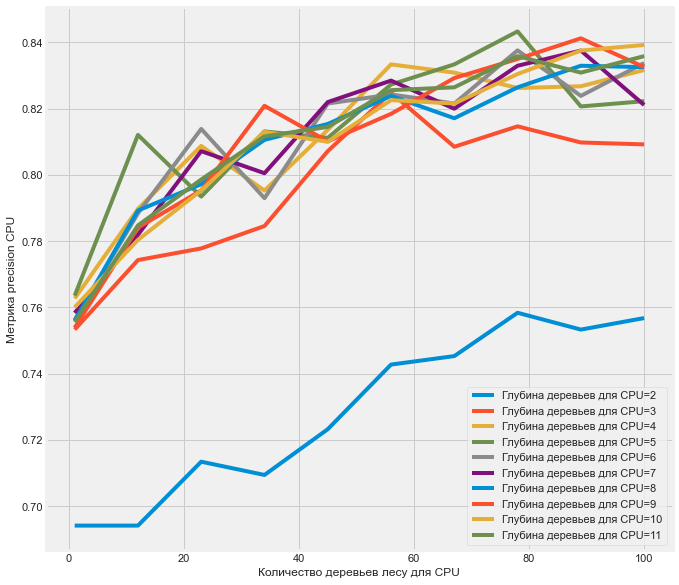

In [167]:
plt.figure(figsize=(10,10))
for i in range(scores1.shape[0]):
    plt.plot(np.linspace(1, 100, 10), scores1[i], label='Глубина деревьев для CPU=' + str(np.arange(2, 12)[i]))
plt.legend()
plt.xlabel('Количество деревьев лесу для CPU')
plt.ylabel('Метрика precision CPU')

Text(0, 0.5, 'Метрика precision GPU')

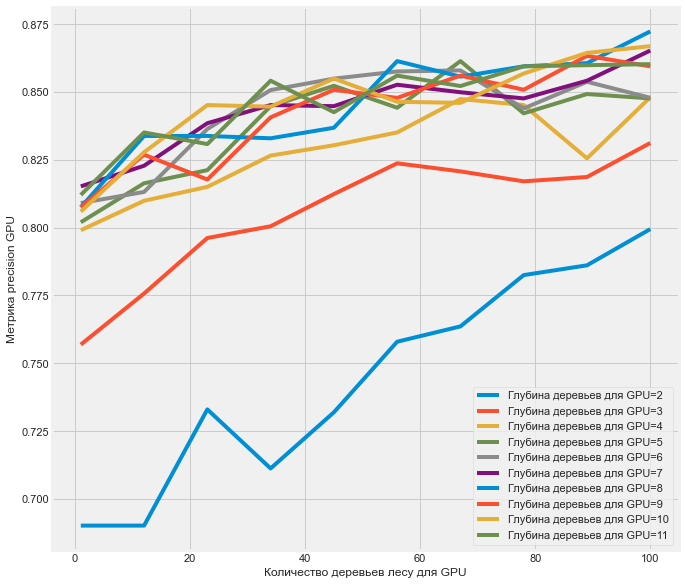

In [168]:
plt.figure(figsize=(10,10))
for i in range(scores.shape[0]):
    plt.plot(np.linspace(1, 100, 10), scores[i], label='Глубина деревьев для GPU=' + str(np.arange(2, 12)[i]))
plt.legend()
plt.xlabel('Количество деревьев лесу для GPU')
plt.ylabel('Метрика precision GPU')




<img src="attachment:10.jpg" width="100">

![title](image/10.jpg) 
|

###   Случайный лес

In [169]:
%%time
linear_preds = RandomForestClassifier().fit(X_train, y_train).predict(X_test)
res5 =  precision_score(y_test, linear_preds)
print(res5)

0.8613333333333333
Wall time: 380 ms
